# Notebook to visualise the glacier projections until 2300 of different large-scale glacier models 
## The created figures are for the ICCI report 2023

In [1]:
# We use the moepy package to compute lowess prediction intervals with bootstrapping methods
# but we don't need it for this notebook, as we precomputed them with 
# the notebook "glacier-model-standard-projections/lowess_percentile_interval_fit_per_region.py"
# to use moepy, do: 
# pip install moepy
# https://ayrtonb.github.io/Merit-Order-Effect/
# from moepy import lowess, eda

In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
matplotlib.rcParams['figure.figsize'] = (14, 8)

In [3]:
# region descriptions ...
d_reg_num_name = {}
d_reg_num_name['global'] = 'Global'
d_reg_num_name['01'] = 'Alaska'
d_reg_num_name['02'] = 'Western Canada & USA'
d_reg_num_name['03'] = 'Arctic Canada North'
d_reg_num_name['04'] = 'Arctic Canada South'
d_reg_num_name['05'] = 'Greenland'
d_reg_num_name['06'] = 'Iceland'
d_reg_num_name['07'] = 'Svalbard and Jan Mayen'
d_reg_num_name['08'] = 'Scandinavia'
d_reg_num_name['09'] = 'Russian Arctic'
d_reg_num_name['10'] = 'North Asia'
d_reg_num_name['11'] = 'Central Europe'
d_reg_num_name['12'] = 'Caucasus and Middle East'
d_reg_num_name['13'] = 'Central Asia'
d_reg_num_name['14'] = 'South Asia West'
d_reg_num_name['15'] = 'South Asia East'
d_reg_num_name['16'] = 'Low Latitudes'
d_reg_num_name['17'] = 'Southern Andes'
d_reg_num_name['18'] = 'New Zealand'
d_reg_num_name['19'] = 'Antarctic and Subantarctic'

d_reg_num_name_icci = {}
d_reg_num_name_icci_reg = {'low-latitudes':['16'], 'mid-latitudes':['08', '11','02','18'], 'polar-hma':['06','13-14-15','01','04','17']}
d_reg_num_name_icci_reg['Glaciers globally'] = ['global']

d_reg_num_name_icci['global'] = 'Glaciers globally'
d_reg_num_name_icci['01'] = 'Glaciers of Alaska'
d_reg_num_name_icci['02'] = 'Glaciers of Western Canada & US'
d_reg_num_name_icci['03'] = 'Glaciers of Arctic Canada (North)'
d_reg_num_name_icci['04'] = 'Glaciers of Arctic Canada (South)'
d_reg_num_name_icci['05'] = 'Glaciers of Greenland'
d_reg_num_name_icci['06'] = 'Glaciers of Iceland'
d_reg_num_name_icci['07'] = 'Glaciers of Svalbard and Jan Mayen'
d_reg_num_name_icci['08'] = 'Glaciers of Scandinavia'
d_reg_num_name_icci['09'] = 'Glaciers of Russian Arctic'
d_reg_num_name_icci['10'] = 'Glaciers of North Asia'
d_reg_num_name_icci['11'] = 'Glaciers of the Alps'
d_reg_num_name_icci['12'] = 'Glaciers of Caucasus and Middle East'
d_reg_num_name_icci['13'] = 'Glaciers of Central Asia'
d_reg_num_name_icci['13-14-15'] = 'Glaciers of High Mountain Asia'
d_reg_num_name_icci['14'] = 'Glaciers of South Asia West'
d_reg_num_name_icci['15'] = 'Glaciers of South Asia East'
d_reg_num_name_icci['16'] = 'Tropical Glaciers'
d_reg_num_name_icci['17'] = 'Glaciers of Patagonia & Southern Andes'
d_reg_num_name_icci['18'] = 'Glaciers of New Zealand'
d_reg_num_name_icci['19'] = 'Glaciers of Antarctic and Subantarctic'

We have extracted the global climate change data in another notebook:
- click on this link to see it: https://nbviewer.org/urls/cluster.klima.uni-bremen.de/~oggm/oggm-standard-projections/analysis_notebooks/global_gcm_climate_cmip6_cmip5.ipynb


In [4]:
# this is where we extracted the global climate change data from:
# https://cluster.klima.uni-bremen.de/~oggm/oggm-standard-projections/analysis_notebooks/global_gcm_climate_cmip6_cmip5.ipynb
try:
    import oggm
    dpath = 'https://cluster.klima.uni-bremen.de/~oggm/oggm-standard-projections/analysis_notebooks'
    _file_cmip5 = oggm.utils.file_downloader(f'{dpath}/Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip5_gcms.csv', reset=True)
    _file_cmip6 = oggm.utils.file_downloader(f'{dpath}/Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip6_gcms.csv', reset=True)
except:
    # you can also just download the file, 
    # e.g. via https://cluster.klima.uni-bremen.de/~oggm/oggm-standard-projections/analysis_notebooks/Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip5_gcms.csv
    # change this path to your local path 
    _file_cmip5 = 'change_to_local_path'
    _file_cmip6 = 'change_to_local_path'
pd_cmip5_temp_ch_2100 = pd.read_csv(_file_cmip5, index_col=0)
pd_cmip5_temp_ch_2100['cmip'] = 'CMIP5'
pd_cmip6_temp_ch_2100 = pd.read_csv(_file_cmip6, index_col=0)
pd_cmip6_temp_ch_2100['cmip'] = 'CMIP6'

pd_cmip_temp_ch_2100 = pd.concat([pd_cmip6_temp_ch_2100, pd_cmip5_temp_ch_2100])
pd_cmip_temp_ch_2100 = pd_cmip_temp_ch_2100.loc[pd_cmip_temp_ch_2100.ssp != 'ssp534-over']
pd_cmip_temp_ch_2100_gcm_until_2300 = pd_cmip_temp_ch_2100.loc[pd_cmip_temp_ch_2100['global_temp_ch_2271-2300_preindustrial'].dropna().index]

from sklearn.preprocessing import MinMaxScaler
data_temp = pd_cmip_temp_ch_2100_gcm_until_2300['global_temp_ch_2071-2100_preindustrial'].values.reshape(1,-1).T
scaler = MinMaxScaler()
scaler.fit(data_temp)
t_min, t_max = pd_cmip_temp_ch_2100_gcm_until_2300['global_temp_ch_2071-2100_preindustrial'].min(), pd_cmip_temp_ch_2100_gcm_until_2300['global_temp_ch_2071-2100_preindustrial'].max()
print(t_min, t_max)

/home/lilianschuster/anaconda3/envs/oggm_v16/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


1.427504187860568 6.274634111566688


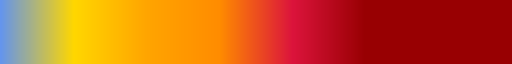

In [5]:
######################

from scipy.optimize import curve_fit

# the exponential decay fit is just to compare to the LOWESS fit (but we only use it in the appendix_fit figures)
def exponential_decay(x, a, b):
    # avoind overflow -> does not work ... 
    exp_values = -b * x
    #exp_values = np.clip(exp_values, -709, 709)  # Clip values to avoid overflow
    return a * np.exp(exp_values) #+ c * np.exp(-d * x**2)#**c 


param_bounds = ([0, 0], [2000, 5])

rgi_regs_global = ['global','01', '02', '03', '04', '05', '06', '07',
                   '08', '09', '10', '11', '12', '13', '14', '15',
                   '16', '17', '18', '19']
rgi_regs_global.append('13-14-15')
path_oggm = 'glacier_model_csv_files/OGGM/'
path_glogem = 'glacier_model_csv_files/GloGEM/'
path_pygem =  'glacier_model_csv_files/PyGEM-OGGM/'

path_d = {}
path_d['OGGM']  = path_oggm
path_d['GloGEM'] = path_glogem
path_d['PyGEM-OGGM'] = path_pygem

# we sort it here into temperature levels, but we only use it internally to do the plots 
colors_temp_values = {'<=+1.5°C':1.5,'<=+2.0°C':2.0,'<=+3.0°C':3.0, '<=+4.0°C':4.0} #, '>4.0°C':5.0}
colors_temp = {'<=+1.5°C':'cyan','<=+2.0°C':'blue','<=+3.0°C':'orange', '<=+4.0°C':'red', '>4.0°C':'purple'}

from matplotlib.colors import LinearSegmentedColormap
colors_temp4_l = ['cornflowerblue', 'gold', 'orange', 'darkorange', 'crimson', '#980002', '#980002', '#980002']
cmap_blue_orange = LinearSegmentedColormap.from_list('bins_100',colors_temp4_l, N=1000)
cmap_blue_orange

**lowess fits with MoePy**

In [6]:
# this is algorithm 2 which does some trial and error but also includes some expert knowledge
def select_frac_alg(sel_it, sim_year=2100):            
    repeat = True
    problem = False
    diff_min = 0
    min_add_q50 = 0
    while repeat:
        _sel = sel_it.loc[sel_it.year == sim_year].copy()
        if sim_year == 2300:
            # brute-force, rather try not to be completely linear for year 2300 
            _sel = _sel.loc[_sel.frac<=0.75]

        # also make sure to select a non-negative median
        # this does NOT work in some regions, we have to clip negative values afterwards ... 
        _sel = _sel.loc[(_sel['min_q50']>= -1+min_add_q50) | (_sel['min_q50'] >= _sel['min_q50'].max())]

        # first choose only those fracs that somehow are the most "monotonic" decreasing 
        min_q_diff = _sel[['min_q05_diff','min_q25_diff','min_q50_diff','min_q75_diff','min_q95_diff']].min(axis=1)

        _sel.loc[min_q_diff.index,'min_q_diff'] = min_q_diff.values
        max_min_q_diff = _sel['min_q_diff'].max()
        # we add -0.2 to allow not only the best "frac", but also others ... 
        _sel = _sel.loc[_sel['min_q_diff'] >= max_min_q_diff-0.2]

        _sel = _sel.loc[_sel.min_q50_diff>=-0.01-diff_min/5]
        _sel = _sel.loc[_sel.min_q95_diff>=-0.01-diff_min]
        _sel = _sel.loc[_sel.min_q75_diff>=-0.01-diff_min]
        _sel = _sel.loc[_sel.min_q25_diff>=-0.01-diff_min]
        _sel = _sel.loc[_sel.min_q05_diff>=-0.01-diff_min]

        _val = _sel.min_q50_diff.max() if _sel.min_q50_diff.max() <=0 else 0
        _sel = _sel.loc[_sel.min_q50_diff >=_val*1.01]

        _val = _sel.min_q50.max() if _sel.min_q50.max() <=0 else 0
        _sel = _sel.loc[_sel.min_q50 >=_val]
        _val = _sel.min_q05.max() if _sel.min_q05.max()<=0 else 0
        _sel = _sel.loc[_sel.min_q05 >=_val]
        if len(_sel) == 97:
            frac = np.round(_sel.frac.unique(),2)[0]
            repeat = False

        elif len(_sel)>97:
            frac = np.round(_sel.frac.unique().max(),2)
            _sel = _sel.loc[_sel.frac == _sel.frac.unique().max()]
            repeat = False
        else:
            repeat = True
            diff_min = diff_min + 0.01
        if max_min_q_diff <-0.35:
            repeat =True
            min_add_q50 -= 0.5
            if min_add_q50 < -5:
                repeat = False
                #frac = np.round(_sel.frac.unique().max(),2)
                #_sel = _sel.loc[_sel.frac == _sel.frac.unique().max()]
                problem = True

    repeat = True
    while problem:
        print(rgi_reg, 'problem')
        problem = False
        diff_min = 0
        min_add_q50 = 0
        while repeat:
            _sel = sel_it.loc[sel_it.year == sim_year].copy()
            if sim_year == 2300:
                # brute-force, ok, let's be a bit "more" linear
                _sel = _sel.loc[_sel.frac<=0.85]

            # also make sure to select a non-negative median
            # this does NOT work in some regions, we have to clip negative values afterwards ... 
            _sel = _sel.loc[(_sel['min_q50']>= -2+min_add_q50) | (_sel['min_q50'] >= _sel['min_q50'].max())]

            # first choose only those fracs that somehow are the most "monotonic" decreasing 
            min_q_diff = _sel[['min_q05_diff','min_q25_diff','min_q50_diff','min_q75_diff','min_q95_diff']].min(axis=1)

            _sel.loc[min_q_diff.index,'min_q_diff'] = min_q_diff.values
            max_min_q_diff = _sel['min_q_diff'].max()
            # we add -0.2 to allow not only the best "frac", but also others ... 
            _sel = _sel.loc[_sel['min_q_diff'] >= max_min_q_diff-0.2]

            _sel = _sel.loc[_sel.min_q50_diff>=-0.01-diff_min/5]
            _sel = _sel.loc[_sel.min_q95_diff>=-0.01-diff_min]
            _sel = _sel.loc[_sel.min_q75_diff>=-0.01-diff_min]
            _sel = _sel.loc[_sel.min_q25_diff>=-0.01-diff_min]
            _sel = _sel.loc[_sel.min_q05_diff>=-0.01-diff_min]

            _val = _sel.min_q50_diff.max() if _sel.min_q50_diff.max() <=0 else 0
            _sel = _sel.loc[_sel.min_q50_diff >=_val*1.01]

            _val = _sel.min_q50.max() if _sel.min_q50.max() <=0 else 0
            _sel = _sel.loc[_sel.min_q50 >=_val]
            _val = _sel.min_q05.max() if _sel.min_q05.max()<=0 else 0
            _sel = _sel.loc[_sel.min_q05 >=_val]
            if len(_sel) == 97:
                frac = np.round(_sel.frac.unique(),2)[0]
                repeat = False

            elif len(_sel)>97:
                frac = np.round(_sel.frac.unique().max(),2)
                _sel = _sel.loc[_sel.frac == _sel.frac.unique().max()]
                repeat = False
            else:
                repeat = True
                diff_min = diff_min + 0.02
            if max_min_q_diff <-0.5:
                repeat =True
                min_add_q50 -= 0.5
                if min_add_q50 < -5:
                    repeat = False
                    problem = True


    print(rgi_reg, frac, min_add_q50, _sel['min_q50'].min(), max_min_q_diff)
    return frac, _sel
                

**first check the frac dependency, we have applied some expert knowledge in some regions (after having checked the frac dependency)**
- decided by Fabien Maussion and Lilian Schuster

In [8]:
frac_2300_exp_decision = {'RGI17':0.8, 'RGI18':0.8,'RGI02':0.8,  
                          'RGI16':0.7, 'RGI11':0.6, 'RGI08':0.7}

def select_frac_w_experts(sel_it, sim_year=2300):
    region = sel_it.region.unique()[0]
    if (region in frac_2300_exp_decision.keys()) and (sim_year == 2300):
        frac = frac_2300_exp_decision[region]
        _sel = sel_it.loc[sel_it.year == sim_year].copy()
        _sel = _sel.loc[_sel.frac.round(2) == frac]
    else:
        frac, _sel = select_frac_alg(sel_it, sim_year=sim_year)
    return frac, _sel

In [55]:
it = 1
pd_fit_stats_it = pd.read_csv(f'lowess_fit_stats_oct29_predi_all_it{it}.csv')

# from notebook: lowess_percentile_interval_fit_create_fit_data_and_merge_lowess_final_fit_files.ipynb
pd_fit_data_all = pd.read_csv(f'fit_data_temp_evol_global_regional_oggm_pygem_glogem_oct182023.csv', index_col=0)
sim_year = 2300
for reg in list(d_reg_num_name_icci_reg.keys()):
    rgi_regs = d_reg_num_name_icci_reg[reg]
    #fig, axs = plt.subplots(3,2, figsize=(25,22)) #harey=True, sharex=True)
    #fig_fit, axs_fit = plt.subplots(3,2, figsize=(25,22)) #harey=True, sharex=True)
    #axs_fit = axs_fit.flatten()
    #axs = axs.flatten()
    len_sub_p = len(rgi_regs)

    for jj,_rgi_reg in enumerate(rgi_regs): 
        list_index_l = []
        err_l = []
        for m in path_d.keys():
            list_index_l.append(list(pd_cmip_temp_ch_2100.index + '_' + m))
        pd_proj_2100_2300 = pd.DataFrame(index=np.concatenate(list_index_l))
        #pd_proj_2100_2300 = pd.DataFrame(index=pd_cmip_temp_ch_2100.index)

        if _rgi_reg !='global':
            rgi_reg = f'RGI{_rgi_reg}'
        else:
            rgi_reg = _rgi_reg 

        data = pd_fit_data_all.loc[(pd_fit_data_all.year==sim_year) & (pd_fit_data_all.region==rgi_reg)]
        # Generate data looking like cosine
        x = data['global_temp_ch_2071-2100_preindustrial'].values
        y = data['rel_ice_%_2020'].values        

        pd_fit_stats_reg = pd_fit_stats_it.loc[pd_fit_stats_it.region == rgi_reg]
        pd_fit_stats_reg_lowess = pd_fit_stats_reg.loc[pd_fit_stats_reg.fit_opt == 'lowess_predi']
        pd_fit_stats_reg_exp = pd_fit_stats_reg.loc[pd_fit_stats_reg.fit_opt == 'exp']
        sel_it = pd_fit_stats_reg_lowess # we don't have it anymore ... .loc[pd_fit_stats_reg_lowess.it ==it]
        frac_alg, _sel_alg = select_frac_alg(sel_it, sim_year=sim_year)
        frac_alg = np.round(frac_alg,2)
        _sel = sel_it.loc[sel_it.year == sim_year].copy()
        fracs = _sel.frac.unique()

        fig, axs = plt.subplots(7,10, figsize=(70,50), sharey=True)
        axs = axs.flatten()
        jj=0
        plt.suptitle(rgi_reg+ f', it={it}')
        for j,frac in enumerate(fracs):
            frac_r = np.round(frac,2)
            _sel_f = _sel.loc[_sel.frac == frac].copy()
            assert len(_sel_f.frac.unique()) == 1
            min_qs = np.round(_sel_f[['min_q50','min_q05','min_q25','min_q75','min_q95']].min(axis=1).min(),2)
            min_qs_diff = np.round(_sel_f[['min_q05_diff','min_q25_diff','min_q50_diff','min_q75_diff','min_q95_diff']].min(axis=1).min(),2)
            ax = axs[jj]
            ax.set_title(f'{np.round(frac,2)}')

            ax.plot(_sel_f.deltaTemp,
                     _sel_f.q50, lw=3, color='black', alpha = 1, label=f'lowess, frac={frac}')
            ax.fill_between(_sel_f.deltaTemp, _sel_f.q05, _sel_f.q95, lw=3, alpha=0.2, color=f'black', label='90% PI')
            ax.fill_between(_sel_f.deltaTemp, _sel_f.q25, _sel_f.q75, lw=3, alpha=0.4, color=f'black', label = '50% PI (IQR)')
            ax.scatter(x,y, color = 'blue', label='model projections', s=40)
            jj+=1
            if rgi_reg == 'RGI08':
                ax.set_ylim([-1,120])
            ax.text(2.5, ax.get_ylim()[-1]*0.9,
                                   f' min qs: {min_qs},\nmin_qs_diff: {min_qs_diff}', fontsize=18)
            
            if (min_qs>=-3.5) and (min_qs_diff>=-0.9) and (_sel_f['min_q50_diff'].min()>=-0.2):
                ax.text(4, ax.get_ylim()[-1]*0.7,
                                   f' good fit\nby algorithm 1', fontsize=22)
            frac_r == np.round(frac,2)
            if frac_r == frac_alg:
                ax.text(4, ax.get_ylim()[-1]*0.5,
                                   f' chosen fit\nby algorithm 2', fontsize=22, color='black')
                if rgi_reg not in frac_2300_exp_decision.keys():
                    ax.text(4, ax.get_ylim()[-1]*0.3,
                                       f'final decision\nby experts', fontsize=28, color='red')
            if rgi_reg in frac_2300_exp_decision.keys():
                frac_exp = frac_2300_exp_decision[rgi_reg]
                if frac_r == frac_exp:
                    ax.text(4, ax.get_ylim()[-1]*0.3,
                                       f'final decision\nby experts', fontsize=28, color='red')
           
        plt.tight_layout()
        fig.savefig(f'figures/appendix_fracs/{sim_year}_lowess_fracs_oggm_glogem_pygem_temp_levels_{rgi_reg}_v3_{it}.png')
        plt.close()

RGI16 problem
RGI16 0.8 -2.0 -3.6536700397631856 -0.3792888174594004
RGI08 0.67 -0.5 -1.1500212197060011 -0.3084628888246981
RGI11 problem
RGI11 0.8 0 -1.8135322844575616 -0.2882249343312313
RGI02 0.74 -3.5 -4.465209266971082 -0.3436600552033668
RGI18 problem
RGI18 0.8 -0.5 -2.4939965189887108 -0.4151130332801664
RGI06 problem
RGI06 0.8 0 -1.6090488460476096 -0.2584169616942668
RGI13-14-15 0.57 0 -0.0536211913880723 -0.3423459518639633
RGI01 0.57 0 0.4378871108982666 -0.0461755604138239
RGI04 0.72 -0.5 -1.453974934319801 -0.1119918149230363
RGI17 problem
RGI17 0.43 0 0.0086394260179012 -0.3464151442898471
global 0.45 0 0.4881256712591804 -0.18261132766947


# NOW the actual plots:
**without recomputing the lowess values by just showing the deciles**

In [10]:

# this file has been merged in lowess_percentile_interval_fit_create_fit_data_and_merge_lowess_final_fit_files.ipynb
# the actual fits were computed by lowess_percentile_interval_fit_per_region.py
pd_fit_stats = pd.read_csv('lowess_fit_stats_oct29_predi_all_it1.csv', index_col=0)
def boxplot_manual(qs= [0.1,0.5,1,2,3],
                   p = 2300, ax = None, j=0, temp_val = 1.5):
    q05, q25, q50, q75, q95 = qs
    c = cmap(scaler.transform(np.array([temp_val]).reshape(-1,1))).flatten()
    item = {}
    #item["label"] = 'box' # not required
    item["med"] = q50
    item["q1"] = q25
    item["q3"] = q75
    #item["cilo"] = 5.3 # not required
    #item["cihi"] = 5.7 # not required
    item["whislo"] = q05
    item["whishi"] = q95
    stats = [item]
    boxprops = dict(linestyle='-', linewidth=2, color=c)
    whisprops = dict(color=c, linewidth=1)
    flierprops = dict(marker='o', markerfacecolor='green', markersize=0,
                      markeredgecolor='none')
    medianprops = dict(linestyle='-', linewidth=4, color=c)
    ax.bxp(stats, positions = [p + j], showfliers = False,
            flierprops= flierprops, medianprops=medianprops, boxprops=boxprops,
             widths=3, #patch_artist=True,
            whiskerprops=whisprops, capprops = dict(color=c, linewidth=1))
    
add_median = False
color_continuous = True
decile_ticks = True
plt.rc('font', size=26)
it = 1
col_opt = 'blue_orange'
frac_dict = {}
for uncertainty in [ 'boxplot', 'no_uncertainties']: # 'no_uncertainties',
    if uncertainty == 'boxplot':
        num_fits = 1000
        delta_text = 20
        xlim1 = 2325
    else:
        num_fits = 1000 
        delta_text = 4
        xlim1 = 2309
    if col_opt =='cyan':
        cmap = cmap_cyan
    elif col_opt == 'blue':
        cmap = cmap_blue
    elif col_opt == 'blue_orange':
        cmap = cmap_blue_orange
    for reg in list(d_reg_num_name_icci_reg.keys()):
        rgi_regs = d_reg_num_name_icci_reg[reg]
        
        len_sub_p = len(rgi_regs)

        for jj,_rgi_reg in enumerate(rgi_regs): 
            list_index_l = []
            err_l = []
            for m in path_d.keys():
                list_index_l.append(list(pd_cmip_temp_ch_2100.index + '_' + m))
            pd_proj_2100_2300 = pd.DataFrame(index=np.concatenate(list_index_l))

            if _rgi_reg !='global':
                rgi_reg = f'RGI{_rgi_reg}'
            else:
                rgi_reg = _rgi_reg 
                
            ####
            pd_fit_stats_reg = pd_fit_stats.loc[pd_fit_stats.region == rgi_reg]
            pd_fit_stats_reg_lowess = pd_fit_stats_reg.loc[pd_fit_stats_reg.fit_opt == 'lowess_predi']
            pd_fit_stats_reg_exp = pd_fit_stats_reg.loc[pd_fit_stats_reg.fit_opt == 'exp']
            sel_it = pd_fit_stats_reg_lowess # we don't have it anymore ... .loc[pd_fit_stats_reg_lowess.it ==it]

            ######
            fig, ax = plt.subplots(1,1, figsize=(15,10)) 
            fig_fit, axs_fit = plt.subplots(2,1, figsize=(15,20)) 
            
            for end_year,ls in zip(['2300'],['-']):
                #for temp_lev in colors_temp.keys():

                for cmip in ['CMIP5','CMIP6']:
                    pd_cmip = pd_cmip_temp_ch_2100_gcm_until_2300.loc[pd_cmip_temp_ch_2100_gcm_until_2300.ssp != 'ssp534-over']
                    pd_cmip = pd_cmip.loc[pd_cmip.cmip == cmip]
                    # check that there are temperature values in 2300 available ... 
                    pd_cmip = pd_cmip.loc[pd_cmip['global_temp_ch_2271-2300_preindustrial'].dropna().index]
                    for gcm_scenario in pd_cmip.index:
                        df_rel_l = []
                        for m in path_d.keys():
                            try:
                                gcm, scenario = gcm_scenario.split('_')
                                path = path_d[m]
                                gcm_scenario_m = gcm_scenario + '_' + m
                                n = len(gcm_scenario)
                                if _rgi_reg == '13-14-15':
                                    df = 0
                                    for sub_rgi_reg in ['RGI13','RGI14','RGI15']:
                                        idir = path + f'volume/{cmip}/{end_year}/{sub_rgi_reg}/'
                                        _df = pd.read_csv(idir + f'{scenario}.csv', index_col=0)
                                        _df.columns = [g.upper() for g in _df.columns]
                                        _df = _df[gcm.upper()]
                                        df += _df
                                else:
                                    idir = path  + f'volume/{cmip}/{end_year}/{rgi_reg}/'
                                    df = pd.read_csv(idir + f'{scenario}.csv', index_col=0)
                                    df.columns = [g.upper() for g in df.columns]
                                    df = df[gcm.upper()]
                                df = df.loc[2000:]
                                # first do the rolling than the relative estimates .. 
                                df_roll = df.rolling(20, center=True, min_periods=1).mean().dropna()
                                df_rel_roll = 100*df_roll/df_roll.loc[2020]                                    

                                temp_ch = pd_cmip.loc[gcm_scenario, 'global_temp_ch_2071-2100_preindustrial']
                                pd_proj_2100_2300.loc[gcm_scenario_m, 'global_temp_ch_2071-2100_preindustrial'] = temp_ch
                                pd_proj_2100_2300.loc[gcm_scenario_m, f'rel_ice_2100_{rgi_reg}'] = df_rel_roll.loc[2100]

                                color= cmap(scaler.transform(temp_ch.reshape(-1,1))).flatten()
                                if not add_median:
                                    alpha = 0.2
                                    ax.plot(df_rel_roll.loc[2020:2300].index, df_rel_roll.loc[2020:2300], lw=2, color=color,ls=ls, alpha = alpha) 
                                    ax.plot(df_rel_roll.loc[2000:2020].index, df_rel_roll.loc[2000:2020], lw=3, color='black', ls=ls, alpha = alpha)
                                pd_proj_2100_2300.loc[gcm_scenario_m, f'rel_ice_2300_{rgi_reg}'] = df_rel_roll.loc[2300]
                                pd_proj_2100_2300.loc[gcm_scenario_m, 'model'] = m

                                df_rel_l.append(df_rel_roll.loc[2000:2300])
                            except:
                                pass
                        if add_median:
                            if len(df_rel_l) > 0:
                                df_rel_med = pd.DataFrame(df_rel_l).T.median(axis=1)
                                ax.plot(df_rel_med.loc[2020:2300].index, df_rel_med.loc[2020:2300], lw=2, color=color,ls=ls, alpha = 0.4) 
                                ax.plot(df_rel_med.loc[2000:2020].index, df_rel_med.loc[2000:2020], lw=2, color='black', ls=ls, alpha = 0.2)

            ax.set_ylim([0,125])
            ax.set_ylabel('% of Remaining Ice',# (relative to 2020)',
                          fontweight = 'bold')
            ax.set_xlabel('Year',  fontweight = 'bold')
            handles, labels = ax.get_legend_handles_labels()
            for h in handles:
                h.set_linewidth(3)
            ax.legend(handles, labels,
                          handlelength=1,
                          title='Temperature change between 1850-1900 & 2071-2100:', ncol=5)
            ax.legend().remove()

            ax.set_title(d_reg_num_name_icci[_rgi_reg], fontweight='bold')

            pd_proj_2100_2300 = pd_proj_2100_2300.dropna()
            assert len(pd_proj_2100_2300) == 60
            for j,sim_year in enumerate([2100,2300]):
                # choose a "frac" parameter and select the right fitting values 
                frac, _sel = select_frac_w_experts(sel_it, sim_year=sim_year)
                frac_dict[f'{rgi_reg}_{sim_year}'] = frac
                
                ax_fit = axs_fit[j]
                ax_fit.set_title(f'{d_reg_num_name_icci[_rgi_reg]}:  year {sim_year}', fontweight='bold')

                # get the raw data ...
                x = pd_proj_2100_2300['global_temp_ch_2071-2100_preindustrial']
                y = pd_proj_2100_2300[f'rel_ice_{sim_year}_{rgi_reg}']
                
                t_min, t_max = x.min(), x.max()
                if sim_year == 2100:
                    delta_x = 0.002
                else:
                    delta_x = 0.001

                df_quantiles = _sel[['q50','q05','q25','q75','q95']]
                # we just have to clip negative values .... there are still some although we tried to omit them by choosing the best frac ... 
                df_quantiles = df_quantiles.where(df_quantiles>=0, 0)
                _sel_ice_eval = df_quantiles['q50'].values
                _sel_ice_eval_bottom = df_quantiles['q05'].values
                _sel_ice_eval_bottom_iqr = df_quantiles['q25'].values
                _sel_ice_eval_top_iqr = df_quantiles['q75'].values
                _sel_ice_eval_top = df_quantiles['q95'].values

                ax_fit.plot(pd_fit_stats_reg_exp.loc[pd_fit_stats_reg_exp.year ==sim_year].deltaTemp,
                         pd_fit_stats_reg_exp.loc[pd_fit_stats_reg_exp.year ==sim_year].q50, lw=3, color='green', alpha = 0.5, label='exponential fit')
                ax_fit.plot(_sel.deltaTemp,
                         _sel_ice_eval, lw=3, color='black', alpha = 1, label=f'lowess, frac={frac}')
                ax_fit.fill_between(_sel.deltaTemp, _sel_ice_eval_bottom, _sel_ice_eval_top, lw=3, alpha=0.2, color=f'black', label='90% PI')
                ax_fit.fill_between(_sel.deltaTemp, _sel_ice_eval_bottom_iqr, _sel_ice_eval_top_iqr, lw=3, alpha=0.4, color=f'black', label = '50% PI (IQR)')
                
                temp_eval_x = _sel.deltaTemp.values
                sns.scatterplot(ax=ax_fit,
                                data = pd_proj_2100_2300, #.loc[j], 
                                x='global_temp_ch_2071-2100_preindustrial', y=f'rel_ice_{sim_year}_{rgi_reg}',
                                                style='model',
                                hue='global_temp_ch_2071-2100_preindustrial',
                                palette=cmap,      
                                sizes=[150,150,150], size='model') #, legend=)
                ax_fit.legend(fontsize=16, ncols=2)

                ax_fit.set_xlabel('Temperature change between 1850-1900 & 2071-2100')
                ax_fit.set_ylabel(f'% of Remaining Glacier Ice\nin {sim_year} (relative to 2020)')

                for j,temp_lev in enumerate(colors_temp.keys()):

                    # for the annotation in the main plot ... 
                    if temp_lev != '>4.0°C':

                        temp_lev_value = colors_temp_values[temp_lev]
                        color= cmap(scaler.transform(np.array([temp_lev_value]).reshape(-1,1))).flatten()
                        idx_nearest = np.abs(temp_eval_x - temp_lev_value).argmin()
                        if j >0:
                            # check the previous fit, if they overlap, need to shift the text
                            previous_fit = fit.copy()
                        else:
                            previous_fit = 10
                            
                            
                        if previous_fit <4:
                            shift = previous_fit-3.5
                        else:
                            shift = 0
                        
                        fit = _sel_ice_eval[idx_nearest]


                        if sim_year == 2300:
                            loc_2300_stats = 2300 +4 
                        else:
                            loc_2300_stats = 2100
                        #if temp_lev_value>1.5:
                        #    ax.vlines(loc_2300_stats,y_fitted[0], y_fitted[1], color=colors_temp[temp_lev], lw=15, alpha = 0.4)
                        ax.hlines(fit,loc_2300_stats-3, loc_2300_stats+3, lw=8, color=color, zorder=10)

                        if sim_year == 2300:
                            bbox=dict(facecolor='white', edgecolor='white', boxstyle='round', alpha = 0.8)
                            ax.annotate(temp_lev[2:], xy=(2300, fit),
                                        xytext=(loc_2300_stats+delta_text, fit+shift),
                                                    verticalalignment="center",
                                                    color=color, alpha=1, fontweight = 'bold', fontsize=18)
                            _sel_temp_lev_qs = np.array([ _sel_ice_eval_bottom[idx_nearest],
                                                         _sel_ice_eval_bottom_iqr[idx_nearest], _sel_ice_eval[idx_nearest],
                                                         _sel_ice_eval_top_iqr[idx_nearest], _sel_ice_eval_top[idx_nearest]])
                            if uncertainty == 'boxplot':
                                boxplot_manual(qs= _sel_temp_lev_qs,
                                               p = loc_2300_stats+5.5,
                                               ax = ax, j=j*4.1, temp_val = temp_lev_value,
                                               )
                np.testing.assert_allclose(temp_eval_x[::2], np.arange(1.4,6.3,0.1))
                colors_fit = cmap(scaler.transform(temp_eval_x[::2].reshape(-1,1))) # only every decile ... 
                lw = 2
                for c,f in zip(colors_fit, _sel_ice_eval[::2]):
                    ax.hlines(f,loc_2300_stats-1.5, loc_2300_stats+1.5, lw=lw, alpha = 0.5,
                               color=c, zorder=7)

            ax.set_xlim([1997, xlim1])
            if rgi_reg == 'RGI08':
                ax_fit.set_ylim([-0.5, 120])

            ax.set_xticks([2020,2100,2200,2300],[2020,2100,2200,2300])
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            fig.tight_layout()
            fig_fit.tight_layout()
            if uncertainty== 'boxplot':
                
                if add_median:
                    fig.savefig(f'figures/main_figures_with_uncertainties/median_glac_models/png/icci_report_2023_median_lowess_predi_oggm_glogem_pygem_temp_levels_{rgi_reg}_v3_{uncertainty}.png')
                    fig.savefig(f'figures/main_figures_with_uncertainties/median_glac_models/svg/icci_report_2023_median_lowess_predi_oggm_glogem_pygem_temp_levels_{rgi_reg}_v3_{uncertainty}.svg')
                else:
                    fig.savefig(f'figures/main_figures_with_uncertainties/all_glac_models/png/icci_report_2023_lowess_predi_oggm_glogem_pygem_temp_levels_{rgi_reg}_v3_{uncertainty}.png')
                    fig.savefig(f'figures/main_figures_with_uncertainties/all_glac_models/svg/icci_report_2023_lowess_predi_oggm_glogem_pygem_temp_levels_{rgi_reg}_v3_{uncertainty}.svg')
                    if uncertainty == 'boxplot':
                        fig_fit.savefig(f'figures/appendix_fit/lowess_predi_exp_fit_oggm_glogem_pygem_temp_levels_{rgi_reg}_v3.png')
            else:
                if add_median:
                    fig.savefig(f'figures/main_figures_without_uncertainties/median_glac_models/png/icci_report_2023_median_lowess_predi_oggm_glogem_pygem_temp_levels_{rgi_reg}_v3_{uncertainty}.png')
                    fig.savefig(f'figures/main_figures_without_uncertainties/median_glac_models/svg/icci_report_2023_median_lowess_predi_oggm_glogem_pygem_temp_levels_{rgi_reg}_v3_{uncertainty}.svg')
                else:
                    fig.savefig(f'figures/main_figures_without_uncertainties/all_glac_models/png/icci_report_2023_lowess_predi_oggm_glogem_pygem_temp_levels_{rgi_reg}_v3_{uncertainty}.png')
                    fig.savefig(f'figures/main_figures_without_uncertainties/all_glac_models/svg/icci_report_2023_lowess_predi_oggm_glogem_pygem_temp_levels_{rgi_reg}_v3_{uncertainty}.svg')
                    
            plt.close()
            plt.close()
            plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI16 0.41 0 0.5940125822019444 -0.009331074123102


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI08 0.96 0 1.0382209879829225 0.0437381748806752


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI11 0.51 0 0.4329462619194236 -0.0115070402162595


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI02 0.46 0 0.0863687406451393 -0.0073848595658214


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI18 0.86 0 2.421712130179934 0.0639439491791801


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI06 0.99 0 21.31067898391548 0.075307676741005
RGI06 problem
RGI06 0.8 0 -1.6090488460476096 -0.2584169616942668


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI13-14-15 0.99 0 8.45265502846896 0.0300477867204858
RGI13-14-15 0.57 0 -0.0536211913880723 -0.3423459518639633


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI01 0.99 0 24.468128333237928 0.0562669460517852
RGI01 0.57 0 0.4378871108982666 -0.0461755604138239


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI04 0.97 0 17.45129269512268 -0.2584482711844496
RGI04 0.72 -0.5 -1.453974934319801 -0.1119918149230363


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI17 0.99 0 16.27953236489871 0.3190121418276295


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


global 0.99 0 40.35323776152246 0.1281386443393088
global 0.45 0 0.4881256712591804 -0.18261132766947


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI16 0.41 0 0.5940125822019444 -0.009331074123102


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI08 0.96 0 1.0382209879829225 0.0437381748806752


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI11 0.51 0 0.4329462619194236 -0.0115070402162595


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI02 0.46 0 0.0863687406451393 -0.0073848595658214


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI18 0.86 0 2.421712130179934 0.0639439491791801


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI06 0.99 0 21.31067898391548 0.075307676741005
RGI06 problem
RGI06 0.8 0 -1.6090488460476096 -0.2584169616942668


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI13-14-15 0.99 0 8.45265502846896 0.0300477867204858
RGI13-14-15 0.57 0 -0.0536211913880723 -0.3423459518639633


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI01 0.99 0 24.468128333237928 0.0562669460517852
RGI01 0.57 0 0.4378871108982666 -0.0461755604138239


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI04 0.97 0 17.45129269512268 -0.2584482711844496
RGI04 0.72 -0.5 -1.453974934319801 -0.1119918149230363


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI17 0.99 0 16.27953236489871 0.3190121418276295


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


global 0.99 0 40.35323776152246 0.1281386443393088
global 0.45 0 0.4881256712591804 -0.18261132766947


**Create the same figures but now as subplots**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI16 0.41 0 0.5940125822019444 -0.009331074123102


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI08 0.96 0 1.0382209879829225 0.0437381748806752


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI11 0.51 0 0.4329462619194236 -0.0115070402162595


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI02 0.46 0 0.0863687406451393 -0.0073848595658214


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI18 0.86 0 2.421712130179934 0.0639439491791801


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI06 0.99 0 21.31067898391548 0.075307676741005
RGI06 problem
RGI06 0.8 0 -1.6090488460476096 -0.2584169616942668


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI13-14-15 0.99 0 8.45265502846896 0.0300477867204858
RGI13-14-15 0.57 0 -0.0536211913880723 -0.3423459518639633


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI01 0.99 0 24.468128333237928 0.0562669460517852
RGI01 0.57 0 0.4378871108982666 -0.0461755604138239


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI04 0.97 0 17.45129269512268 -0.2584482711844496
RGI04 0.72 -0.5 -1.453974934319801 -0.1119918149230363


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI17 0.99 0 16.27953236489871 0.3190121418276295


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


global 0.99 0 40.35323776152246 0.1281386443393088
global 0.45 0 0.4881256712591804 -0.18261132766947


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI16 0.41 0 0.5940125822019444 -0.009331074123102


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI08 0.96 0 1.0382209879829225 0.0437381748806752


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI11 0.51 0 0.4329462619194236 -0.0115070402162595


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI02 0.46 0 0.0863687406451393 -0.0073848595658214


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI18 0.86 0 2.421712130179934 0.0639439491791801


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI06 0.99 0 21.31067898391548 0.075307676741005
RGI06 problem
RGI06 0.8 0 -1.6090488460476096 -0.2584169616942668


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI13-14-15 0.99 0 8.45265502846896 0.0300477867204858
RGI13-14-15 0.57 0 -0.0536211913880723 -0.3423459518639633


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI01 0.99 0 24.468128333237928 0.0562669460517852
RGI01 0.57 0 0.4378871108982666 -0.0461755604138239


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI04 0.97 0 17.45129269512268 -0.2584482711844496
RGI04 0.72 -0.5 -1.453974934319801 -0.1119918149230363


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RGI17 0.99 0 16.27953236489871 0.3190121418276295


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


global 0.99 0 40.35323776152246 0.1281386443393088
global 0.45 0 0.4881256712591804 -0.18261132766947


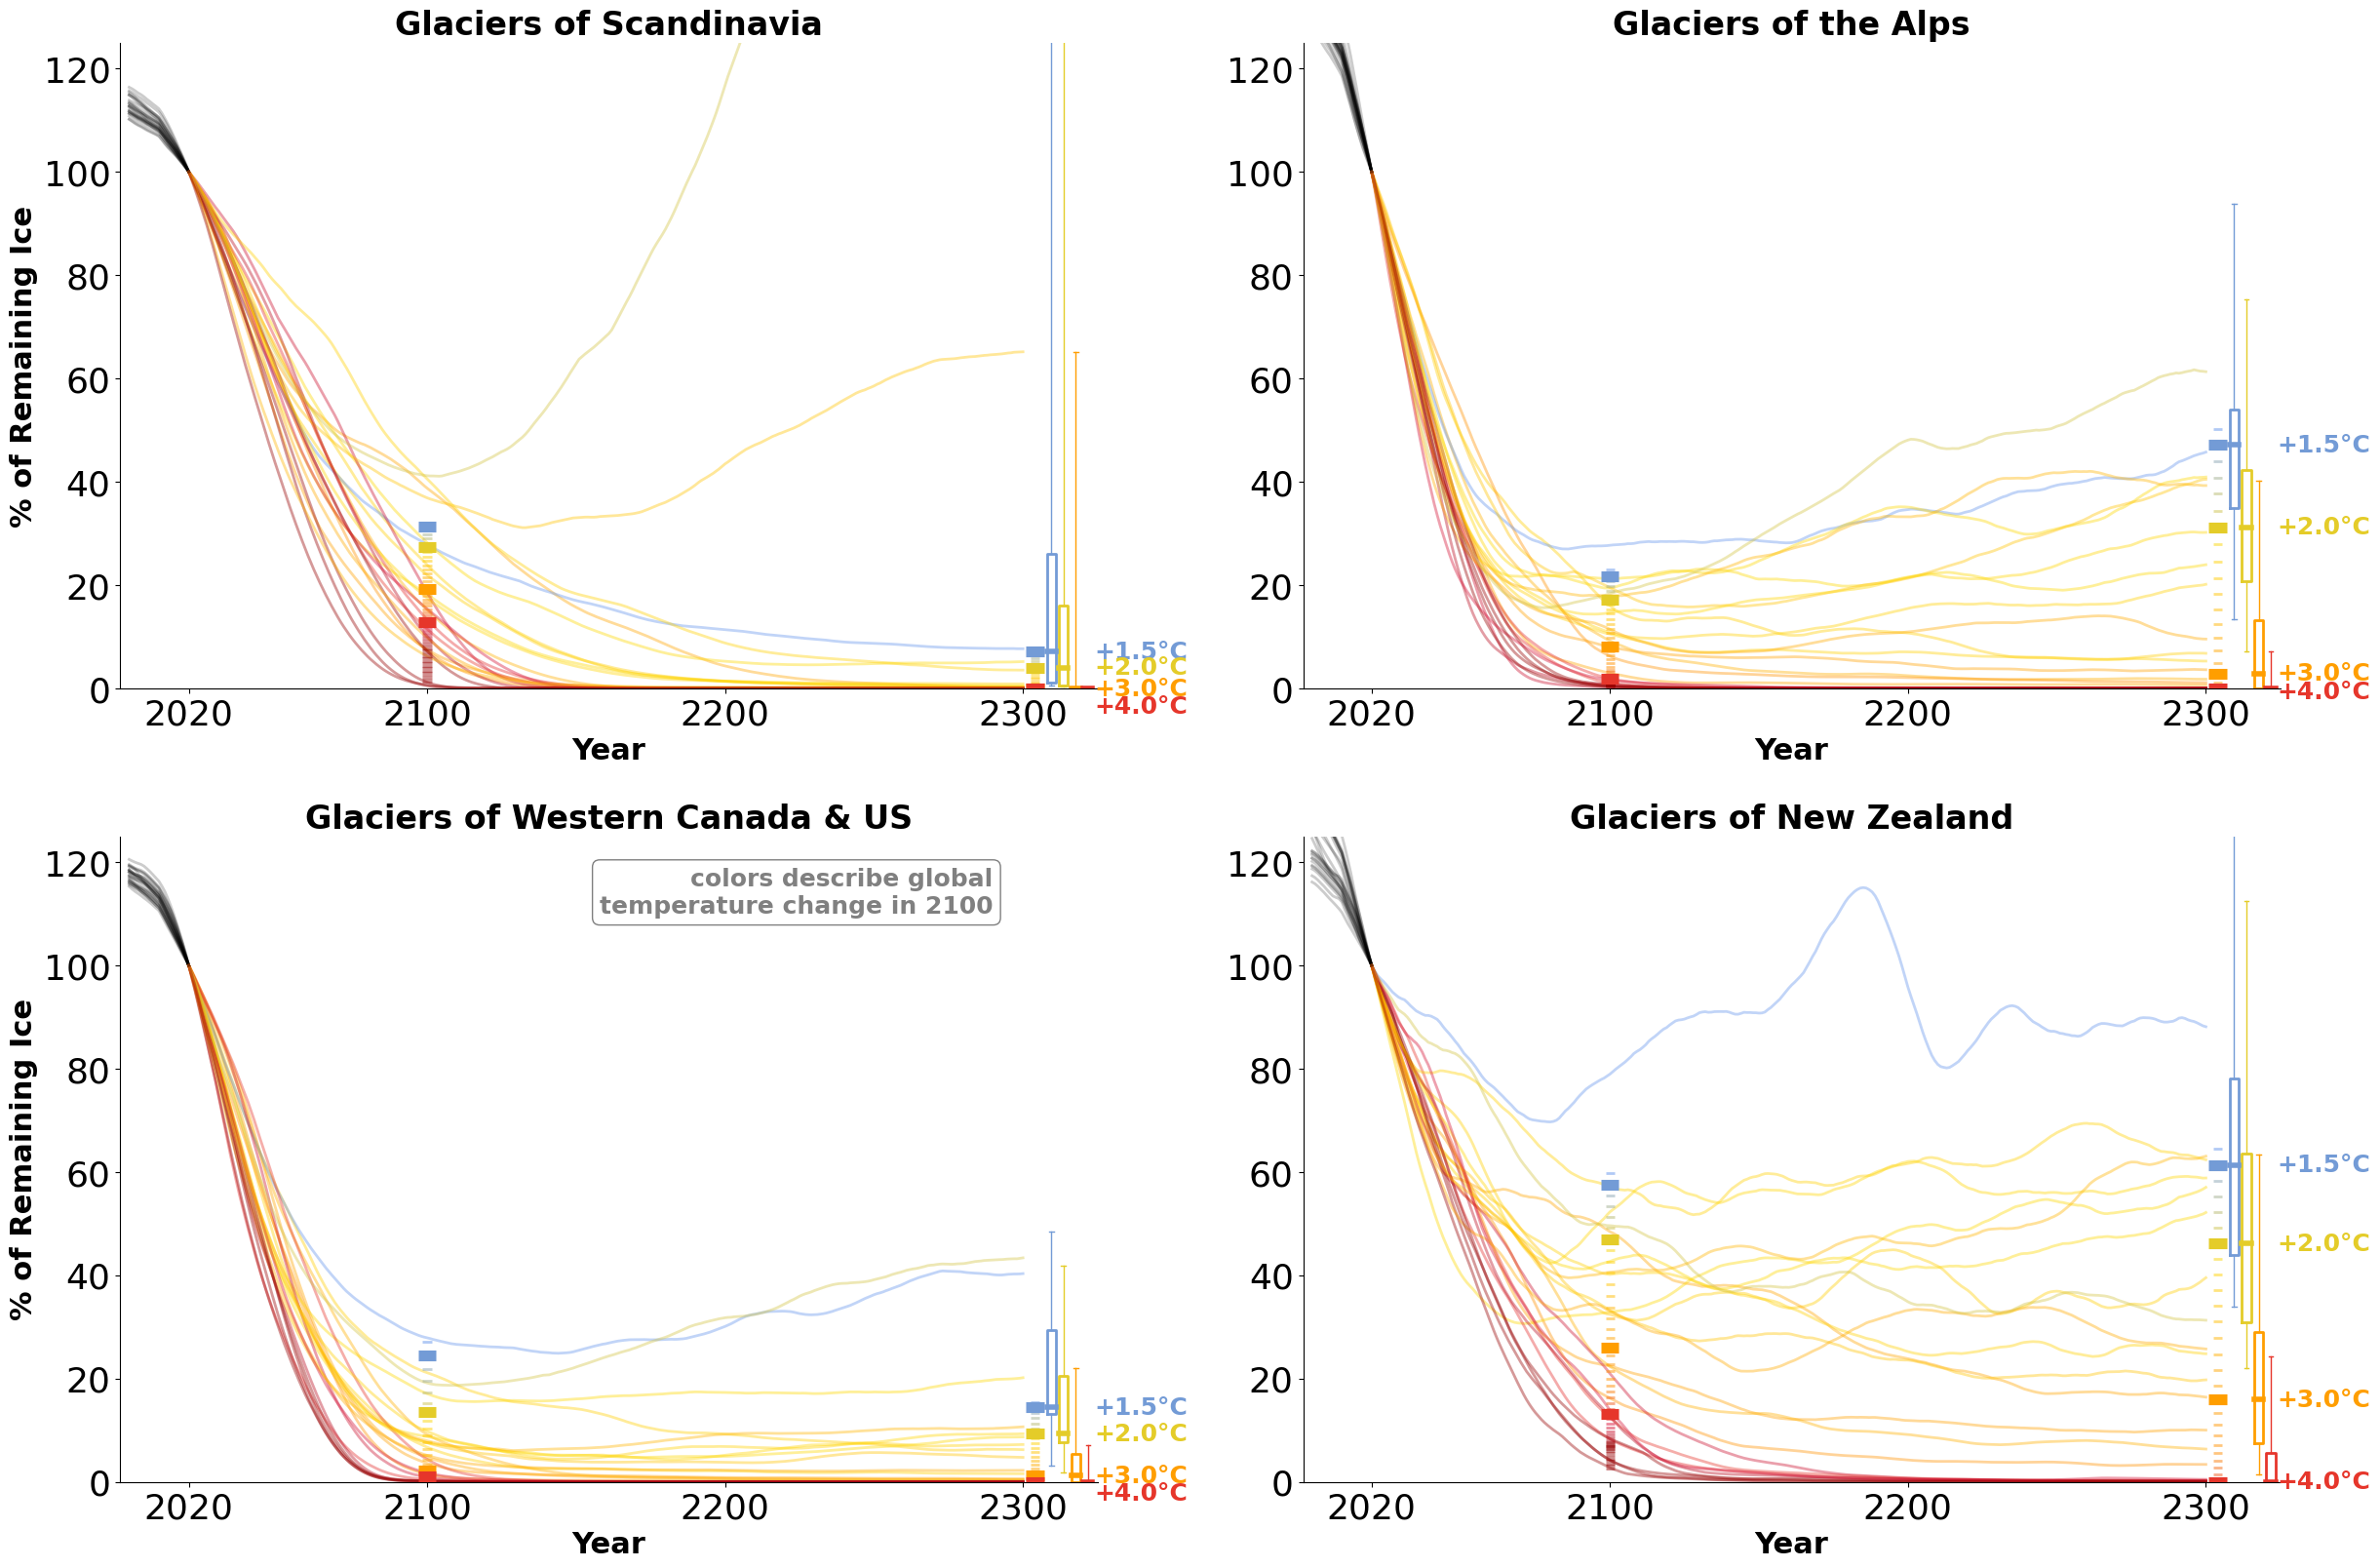

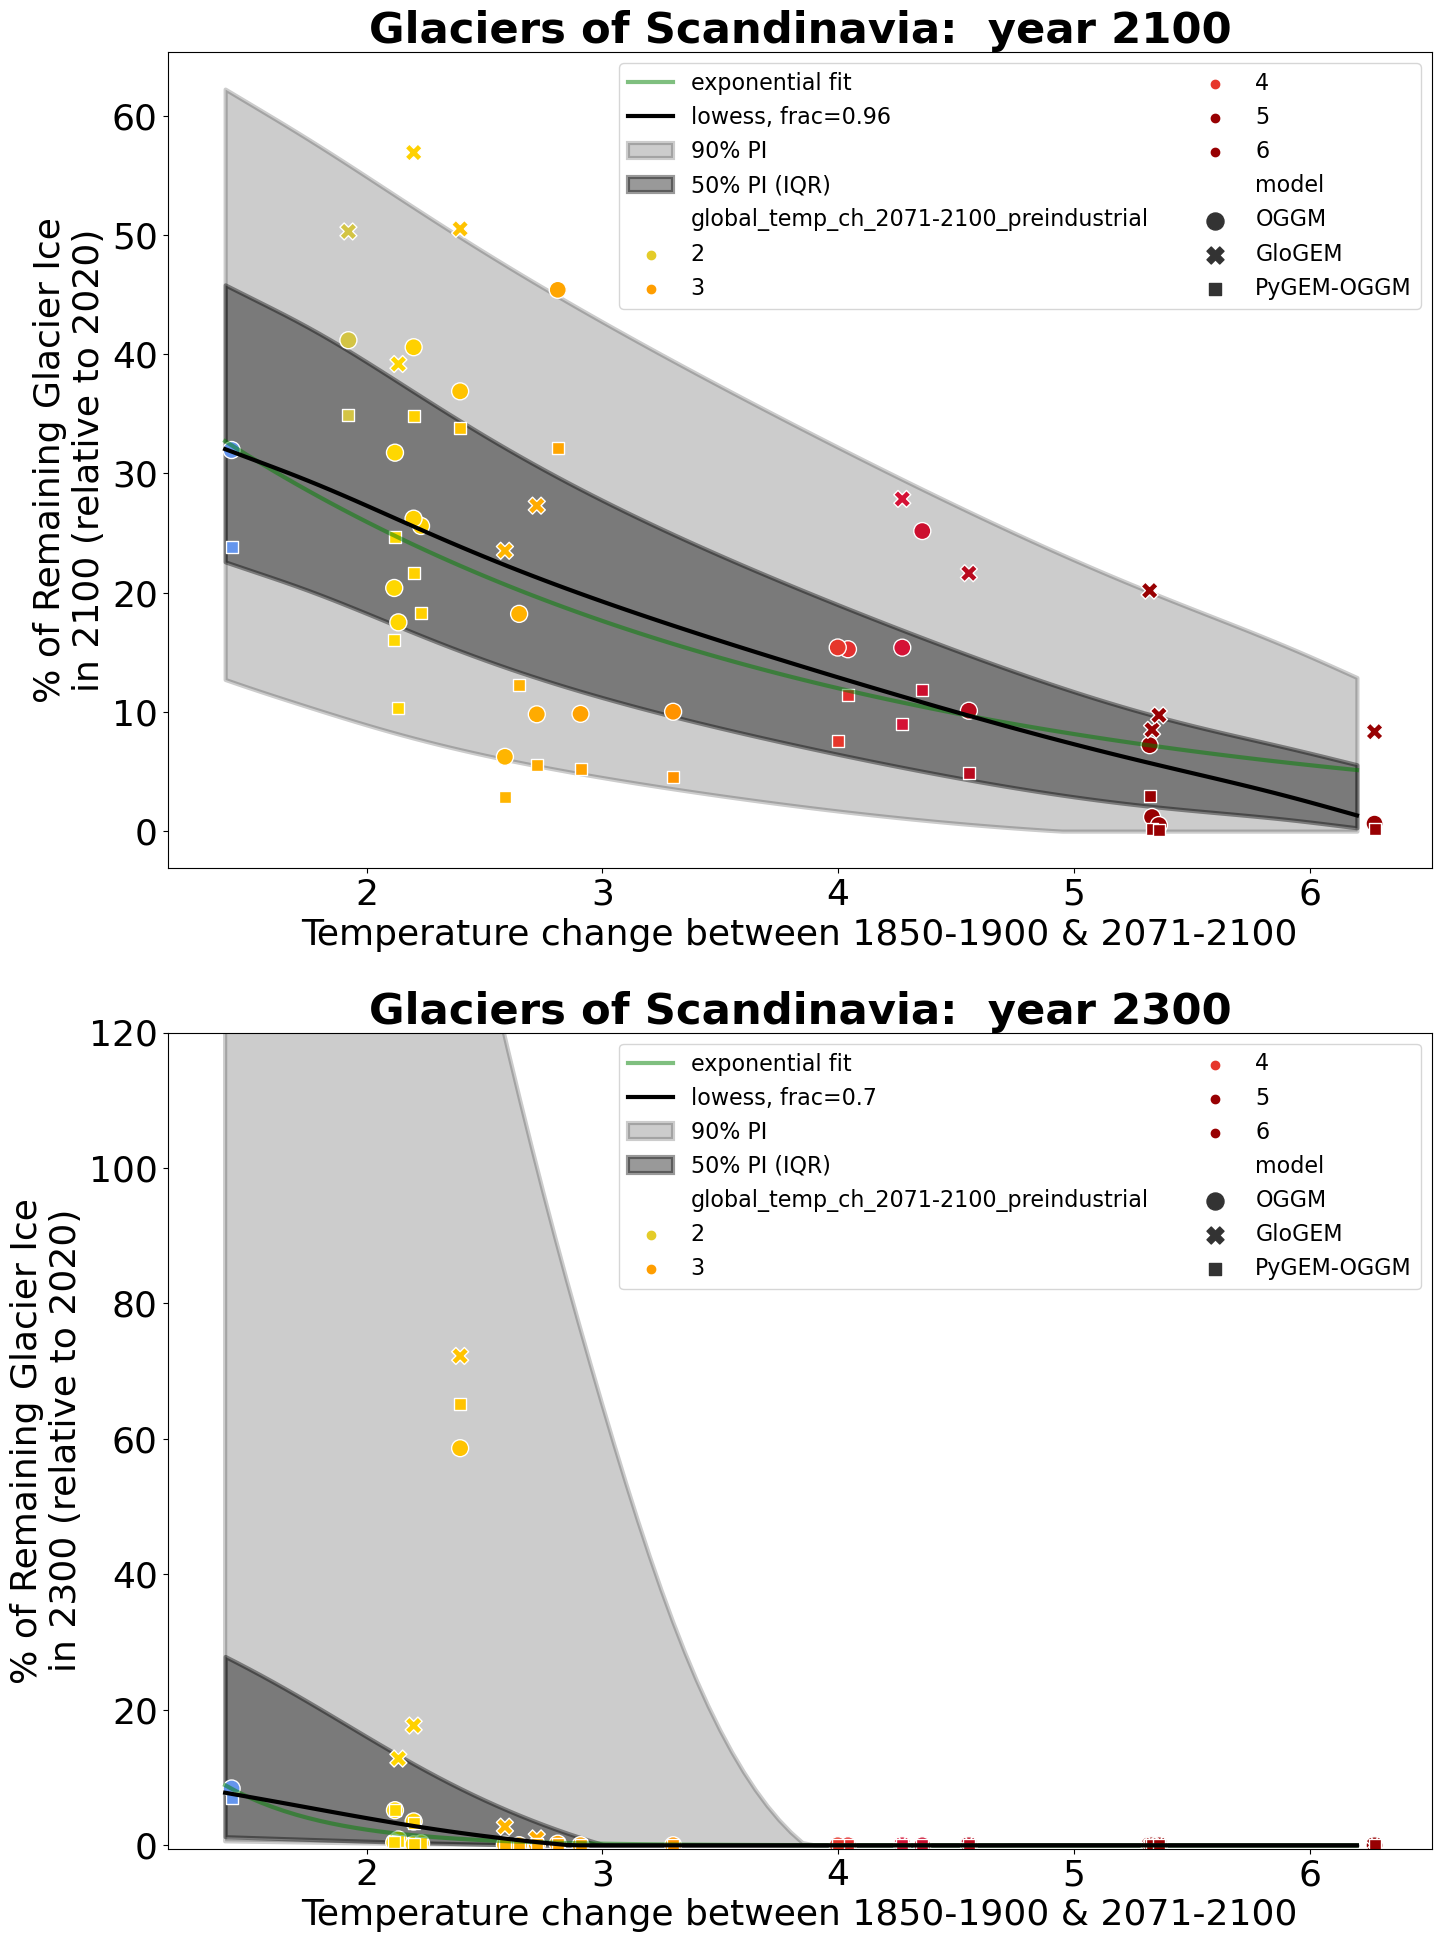

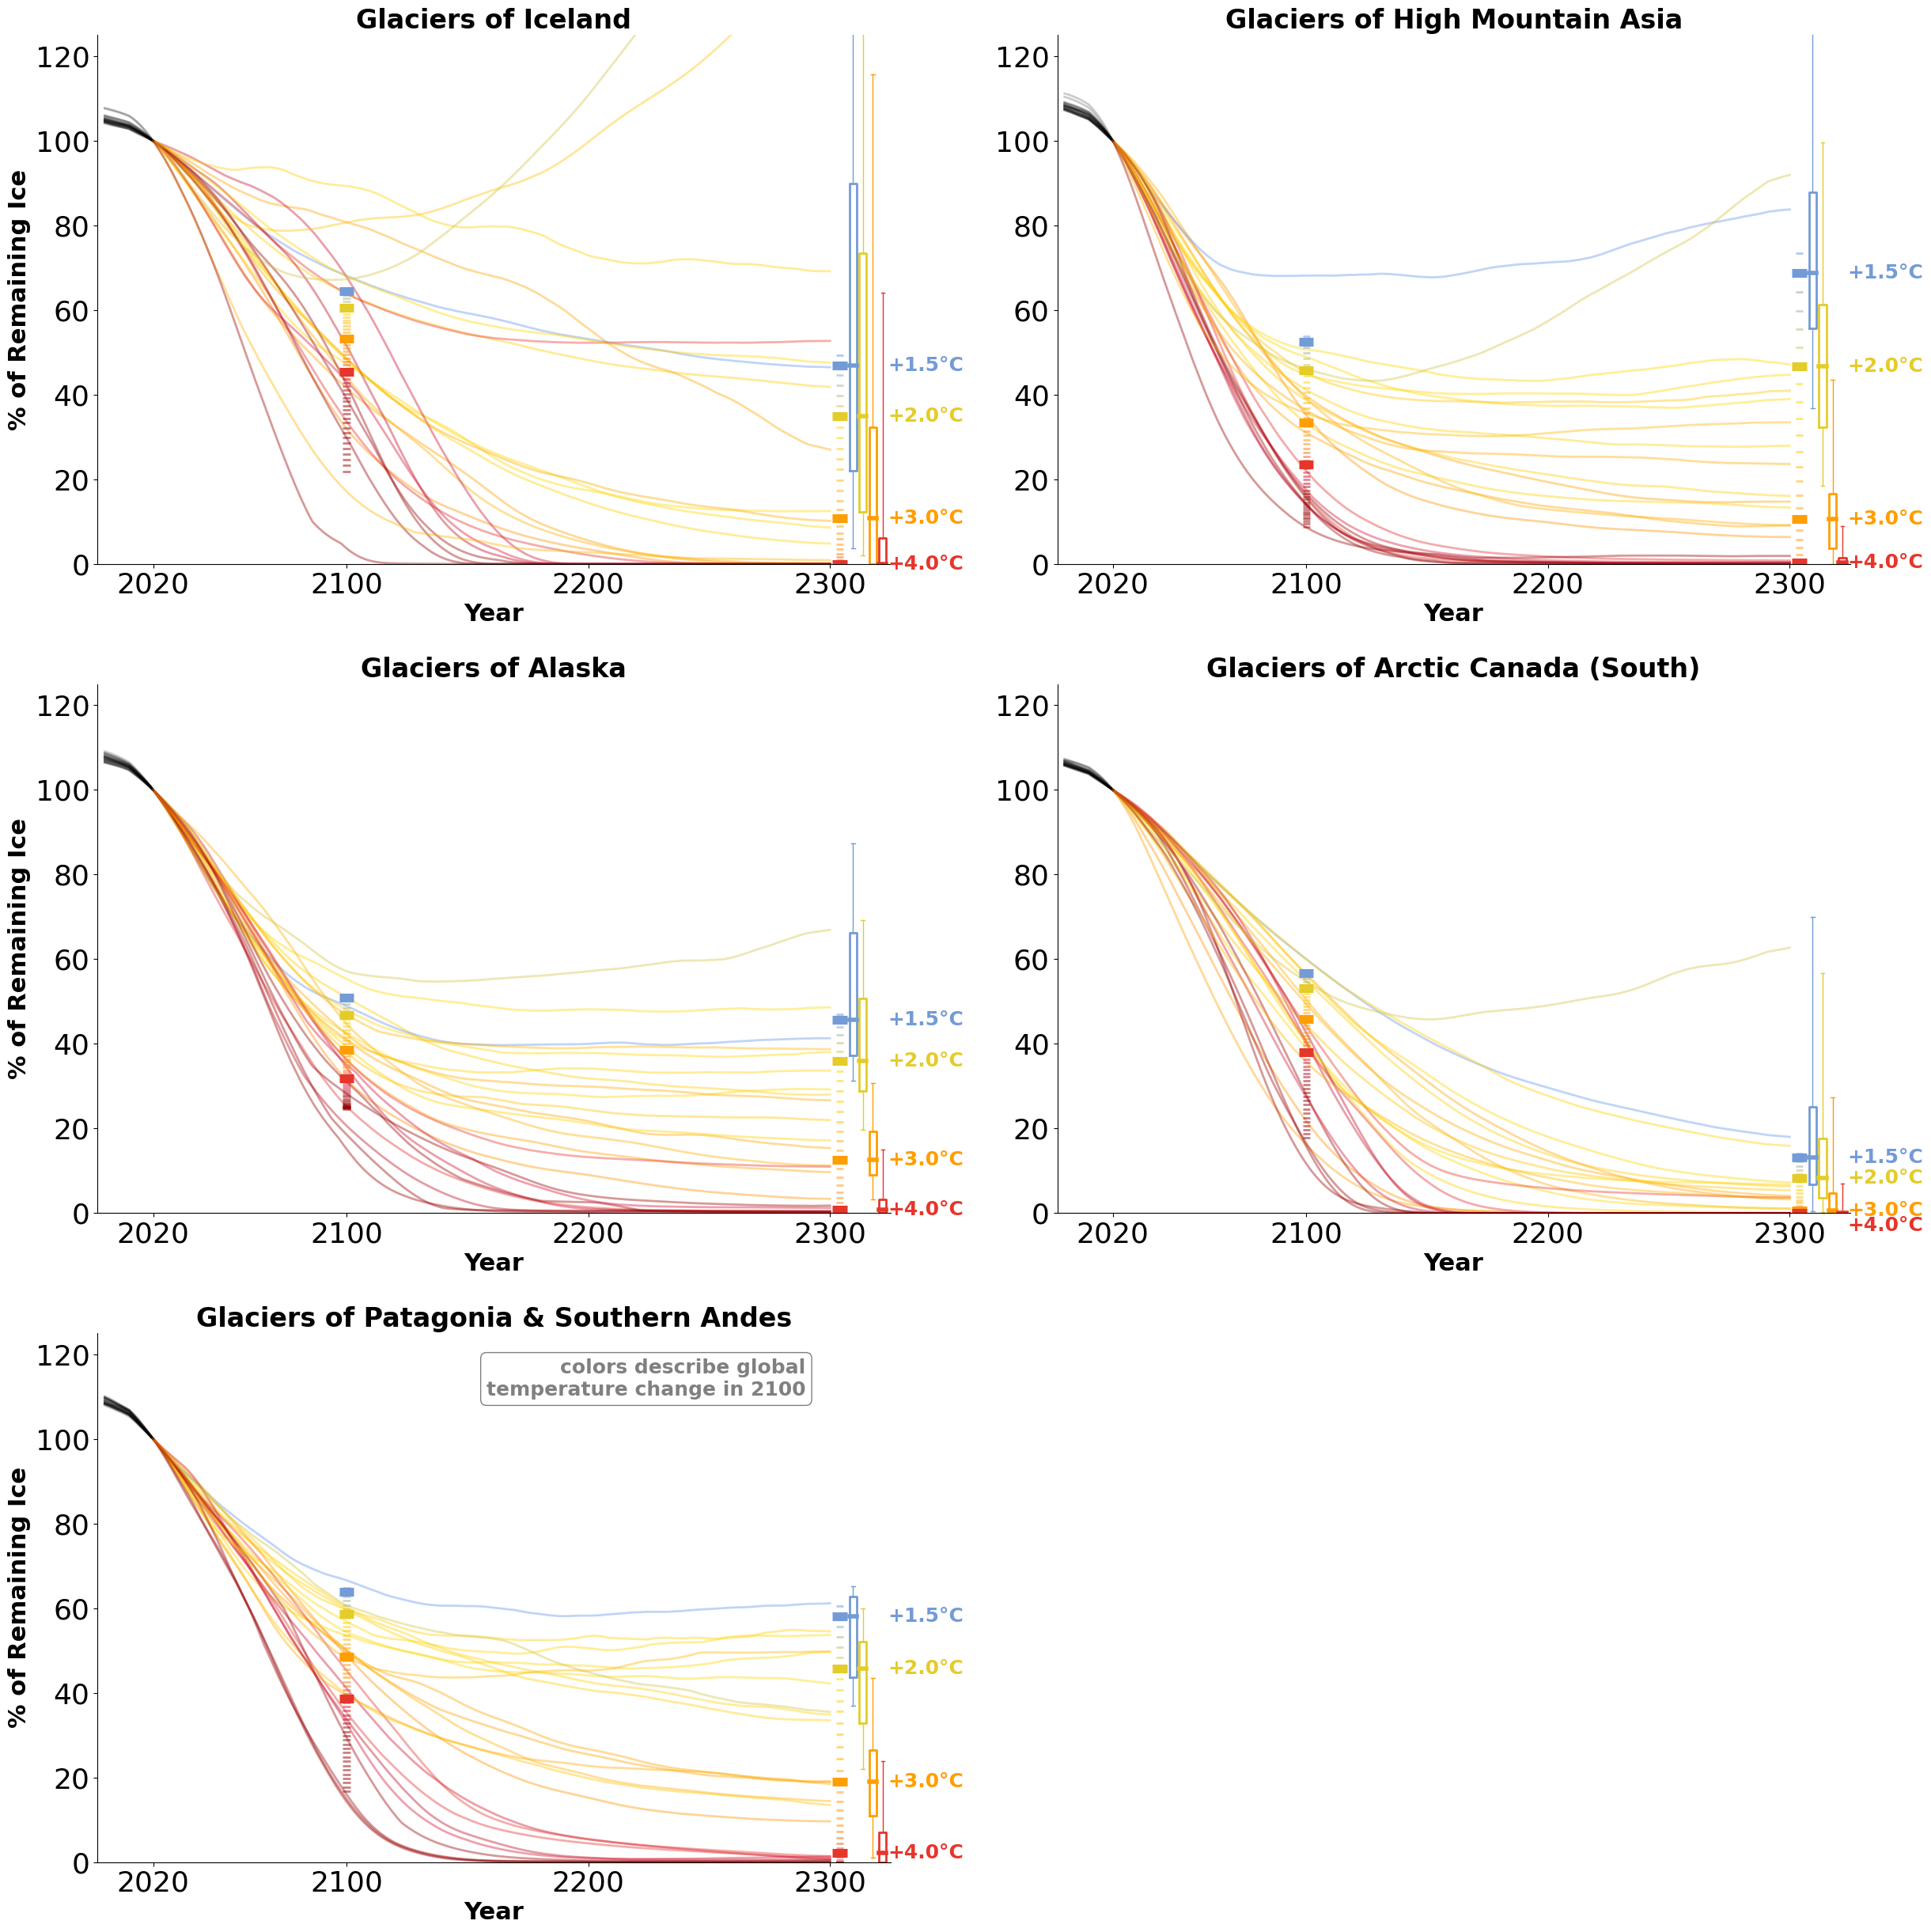

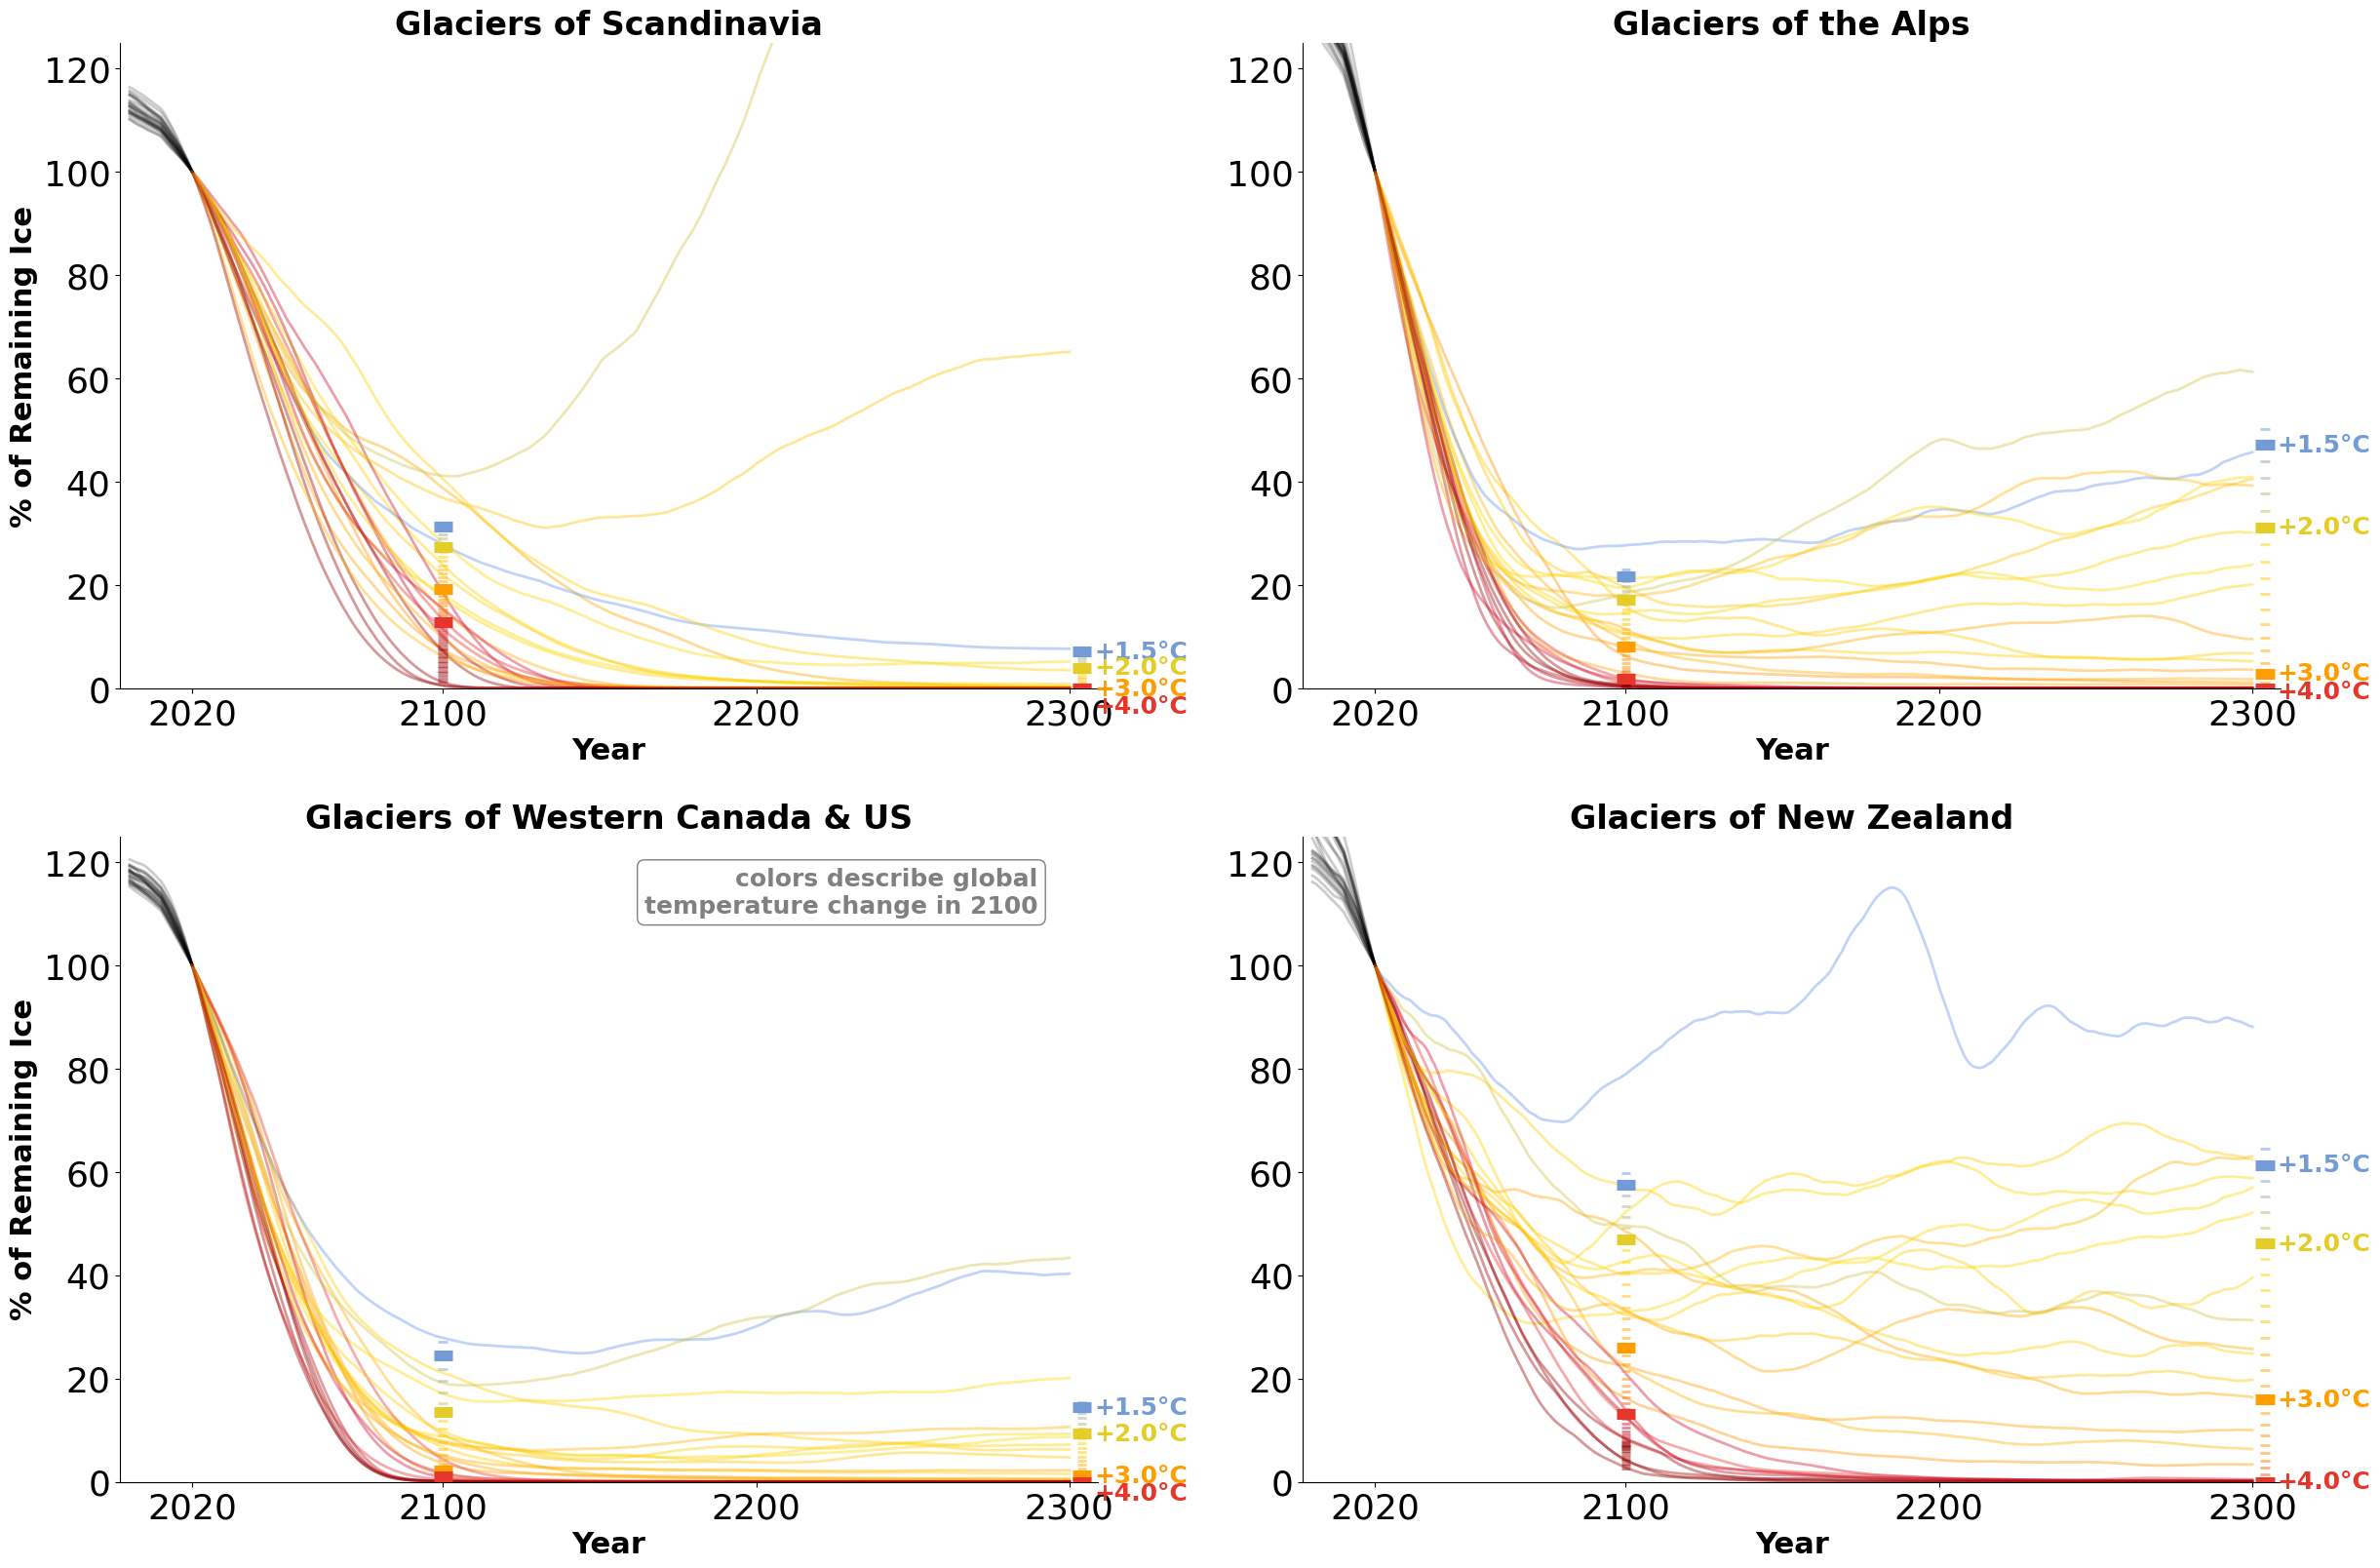

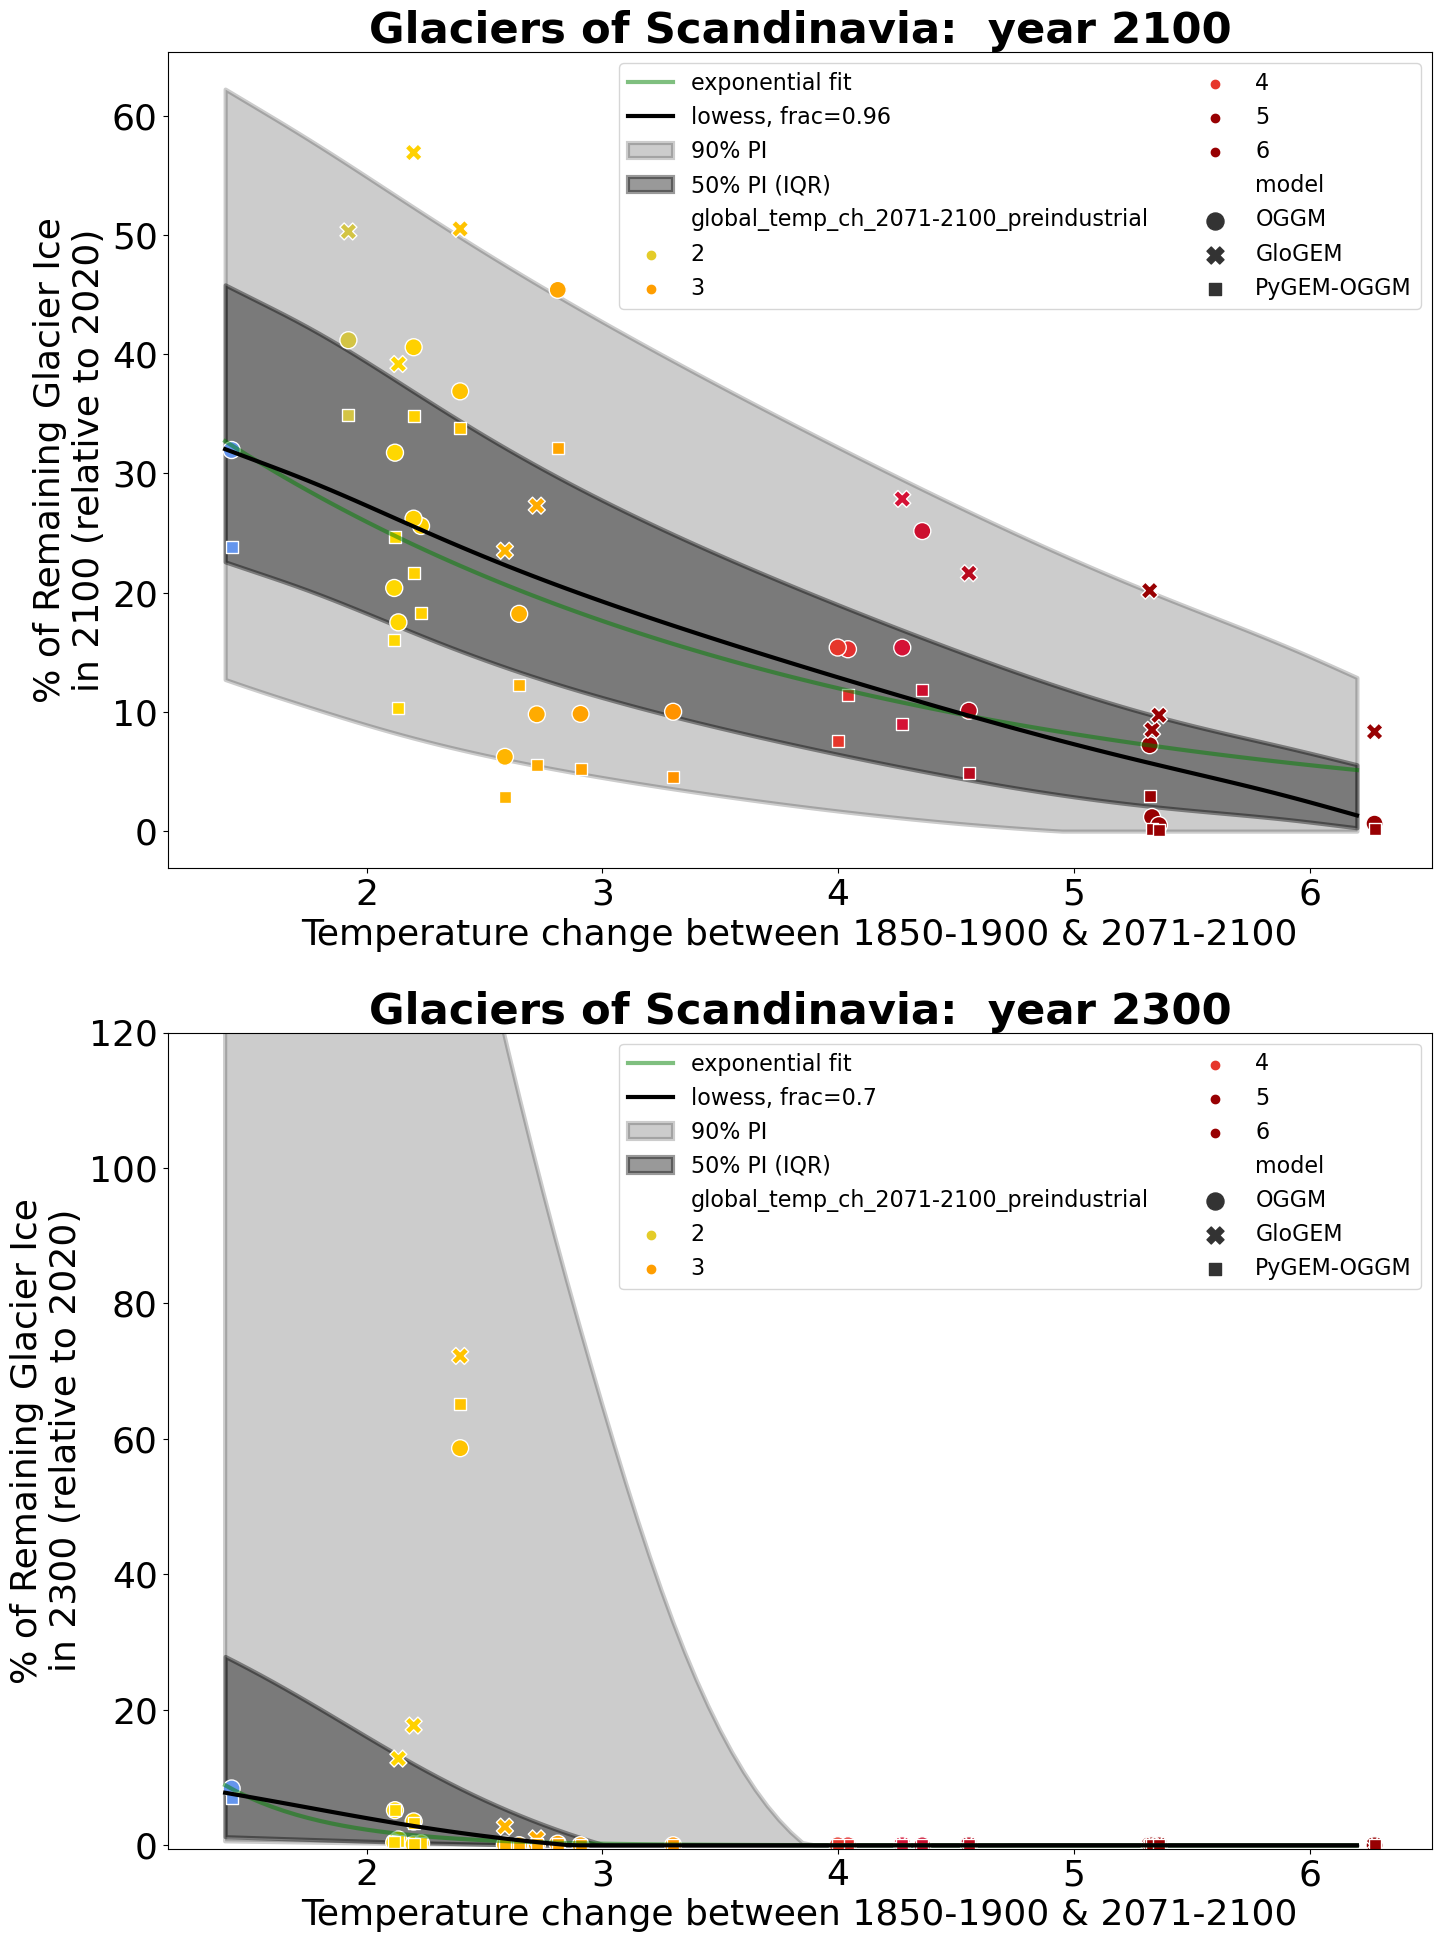

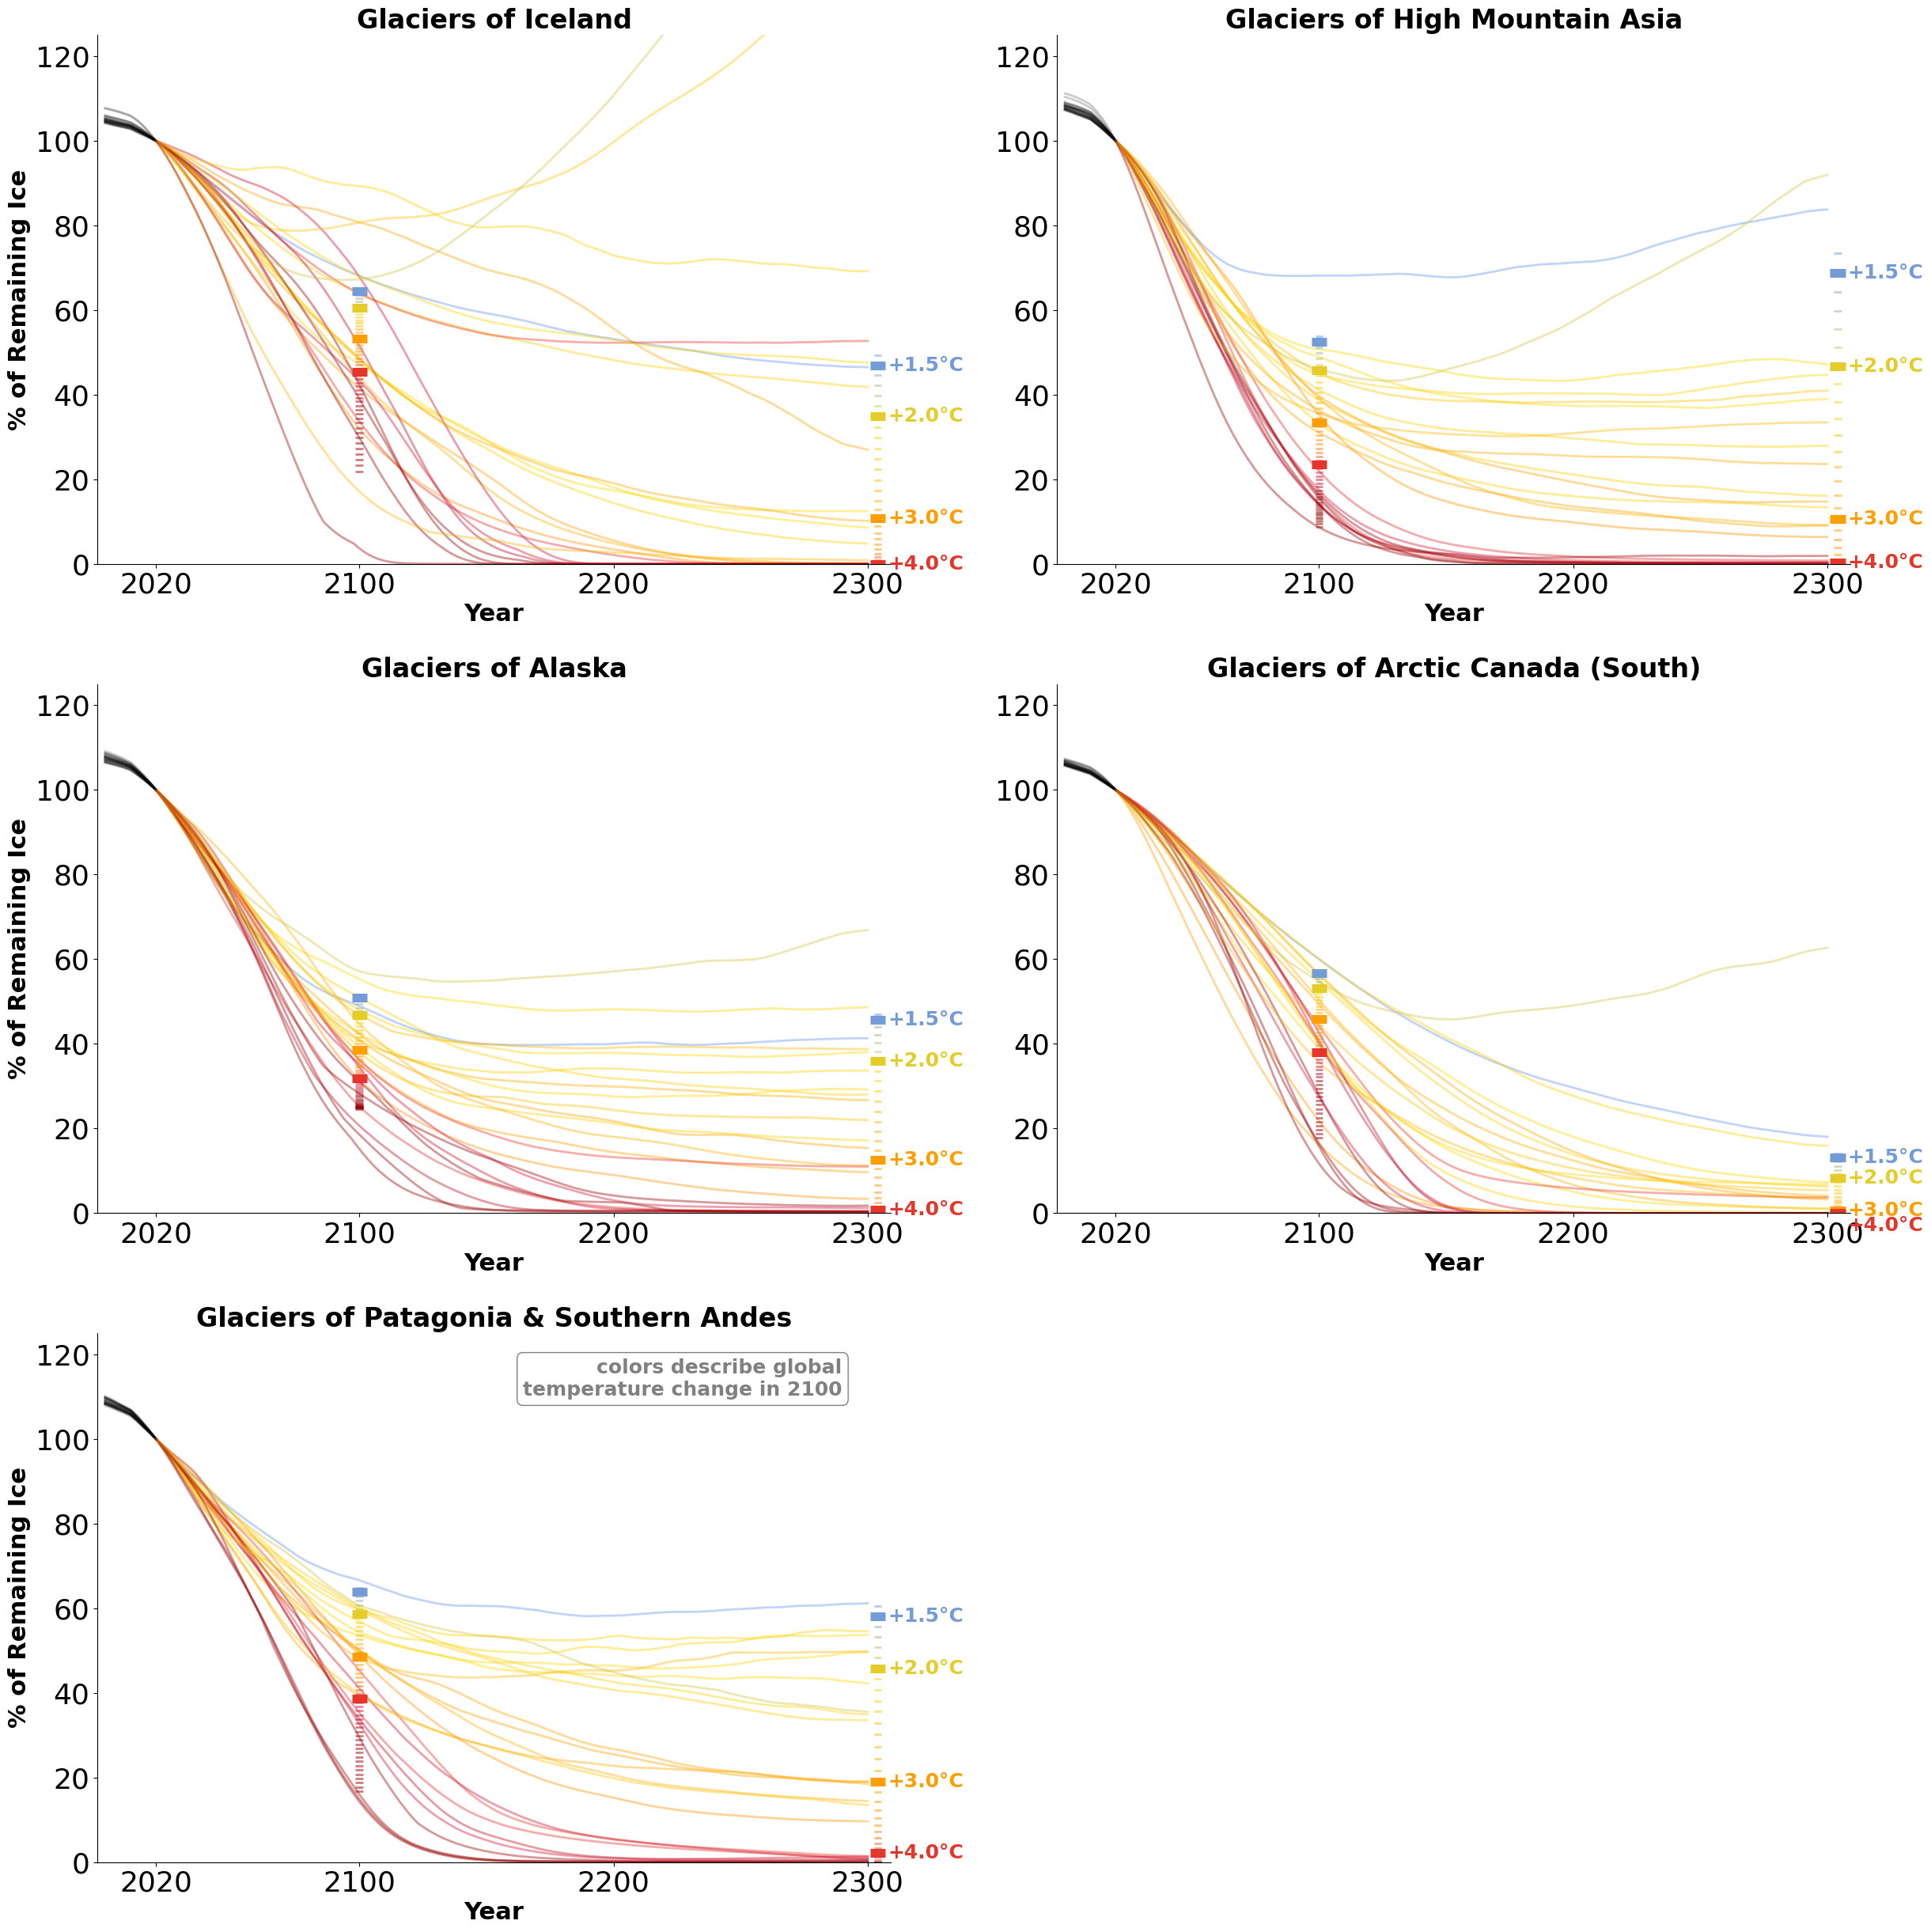

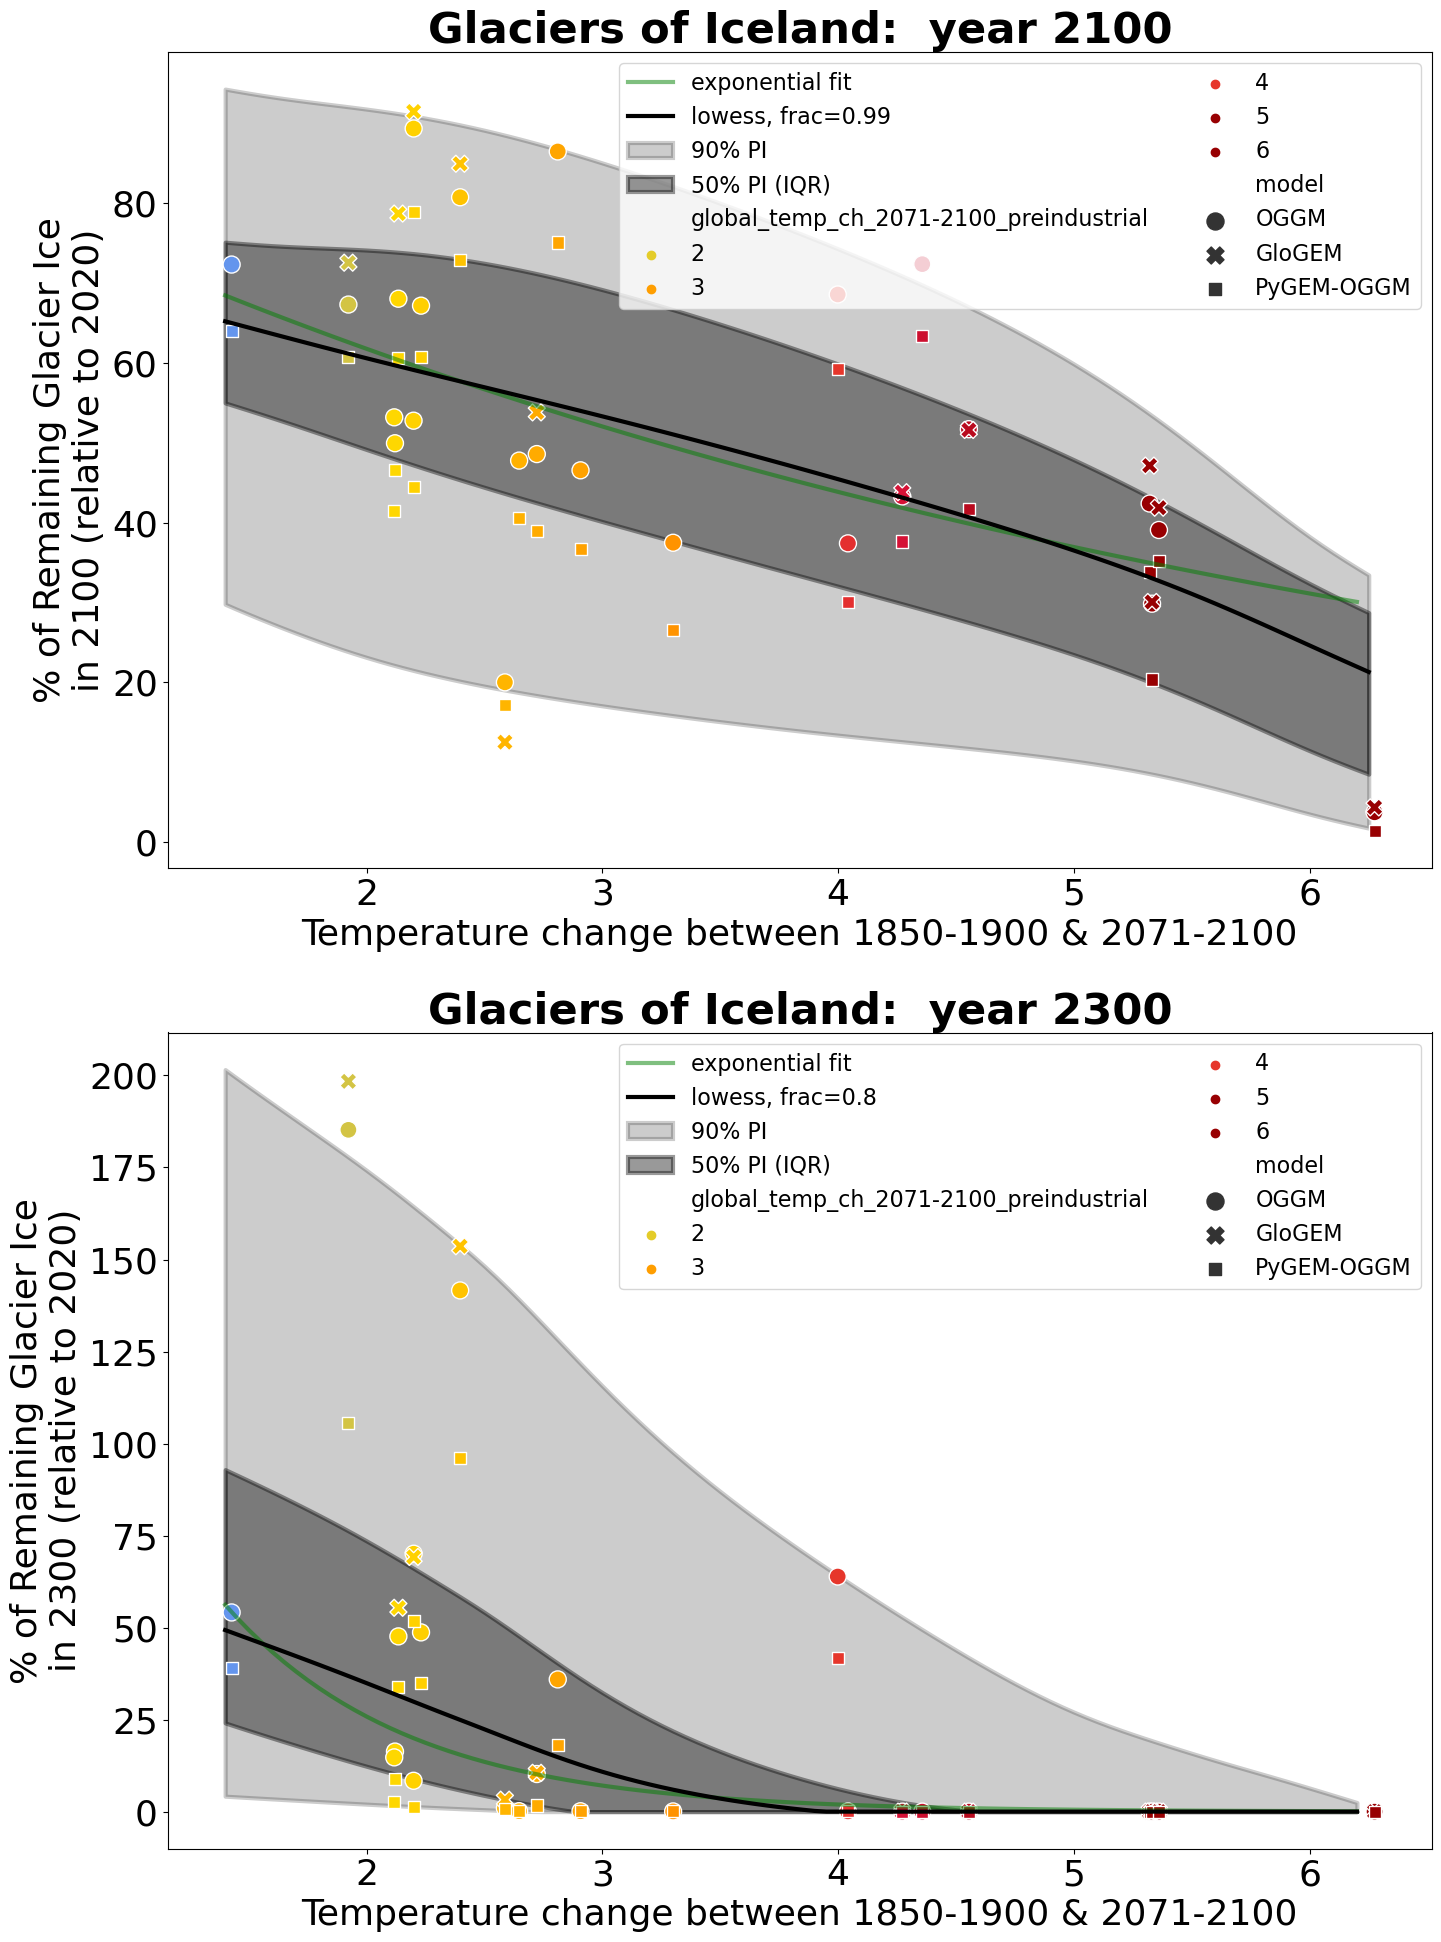

In [14]:

# this file has been merged in lowess_percentile_interval_fit_create_fit_data_and_merge_lowess_final_fit_files.ipynb
# the actual fits were computed by lowess_percentile_interval_fit_per_region.py
pd_fit_stats = pd.read_csv('lowess_fit_stats_oct29_predi_all_it1.csv', index_col=0)
def boxplot_manual(qs= [0.1,0.5,1,2,3],
                   p = 2300, ax = None, j=0, temp_val = 1.5):
    q05, q25, q50, q75, q95 = qs
    c = cmap(scaler.transform(np.array([temp_val]).reshape(-1,1))).flatten()
    item = {}
    #item["label"] = 'box' # not required
    item["med"] = q50
    item["q1"] = q25
    item["q3"] = q75
    #item["cilo"] = 5.3 # not required
    #item["cihi"] = 5.7 # not required
    item["whislo"] = q05
    item["whishi"] = q95
    stats = [item]
    boxprops = dict(linestyle='-', linewidth=2, color=c)
    whisprops = dict(color=c, linewidth=1)
    flierprops = dict(marker='o', markerfacecolor='green', markersize=0,
                      markeredgecolor='none')
    medianprops = dict(linestyle='-', linewidth=4, color=c)
    ax.bxp(stats, positions = [p + j], showfliers = False,
            flierprops= flierprops, medianprops=medianprops, boxprops=boxprops,
             widths=3, #patch_artist=True,
            whiskerprops=whisprops, capprops = dict(color=c, linewidth=1))
    
add_median = True
color_continuous = True
decile_ticks = True
plt.rc('font', size=26)
it = 1
col_opt = 'blue_orange'
frac_dict = {}
for uncertainty in [ 'boxplot', 'no_uncertainties']: # 'no_uncertainties',
    if uncertainty == 'boxplot':
        num_fits = 1000
        delta_text = 20
        xlim1 = 2325
    else:
        num_fits = 1000 
        delta_text = 4
        xlim1 = 2309
    if col_opt =='cyan':
        cmap = cmap_cyan
    elif col_opt == 'blue':
        cmap = cmap_blue
    elif col_opt == 'blue_orange':
        cmap = cmap_blue_orange
    for reg in list(d_reg_num_name_icci_reg.keys()):
        rgi_regs = d_reg_num_name_icci_reg[reg]
        
        len_sub_p = len(rgi_regs)
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        if (reg == 'Glaciers globally') or (reg == 'low-latitudes'):
            fig, axs = plt.subplots(1,1, figsize=(12.5,25/3)) 
            axs = [axs]#.flatten()
            #for a in [1,2,3,4,5]:
            #    axs[a].remove()
            # figure to show caption 
            ax_f = axs[0] 
           
        elif reg == 'mid-latitudes':
            fig, axs = plt.subplots(2,2, figsize=(25,25*2/3))
            axs = axs.flatten()
            #axs[4].remove()
            #axs[5].remove()
            ax_f = axs[2]
        elif reg == 'polar-hma':
            fig, axs = plt.subplots(3,2, figsize=(25,25))
            axs = axs.flatten()
            ax_f = axs[4]
            #ax_f.spines['left'].set_visible(False)
            #ax_f.spines['bottom'].set_visible(False)
            axs[5].remove()
            
        else:
            print('sth. wrong')

        for jj,_rgi_reg in enumerate(rgi_regs): 
            ax = axs[jj]
            list_index_l = []
            err_l = []
            for m in path_d.keys():
                list_index_l.append(list(pd_cmip_temp_ch_2100.index + '_' + m))
            pd_proj_2100_2300 = pd.DataFrame(index=np.concatenate(list_index_l))

            if _rgi_reg !='global':
                rgi_reg = f'RGI{_rgi_reg}'
            else:
                rgi_reg = _rgi_reg 
                
            ####
            pd_fit_stats_reg = pd_fit_stats.loc[pd_fit_stats.region == rgi_reg]
            pd_fit_stats_reg_lowess = pd_fit_stats_reg.loc[pd_fit_stats_reg.fit_opt == 'lowess_predi']
            pd_fit_stats_reg_exp = pd_fit_stats_reg.loc[pd_fit_stats_reg.fit_opt == 'exp']
            sel_it = pd_fit_stats_reg_lowess # we don't have it anymore ... .loc[pd_fit_stats_reg_lowess.it ==it]

            ######
            fig_fit, axs_fit = plt.subplots(2,1, figsize=(15,20)) 
            
            for end_year,ls in zip(['2300'],['-']):
                #for temp_lev in colors_temp.keys():

                for cmip in ['CMIP5','CMIP6']:
                    pd_cmip = pd_cmip_temp_ch_2100_gcm_until_2300.loc[pd_cmip_temp_ch_2100_gcm_until_2300.ssp != 'ssp534-over']
                    pd_cmip = pd_cmip.loc[pd_cmip.cmip == cmip]
                    # check that there are temperature values in 2300 available ... 
                    pd_cmip = pd_cmip.loc[pd_cmip['global_temp_ch_2271-2300_preindustrial'].dropna().index]
                    for gcm_scenario in pd_cmip.index:
                        df_rel_l = []
                        for m in path_d.keys():
                            try:
                                gcm, scenario = gcm_scenario.split('_')
                                path = path_d[m]
                                gcm_scenario_m = gcm_scenario + '_' + m
                                n = len(gcm_scenario)
                                if _rgi_reg == '13-14-15':
                                    df = 0
                                    for sub_rgi_reg in ['RGI13','RGI14','RGI15']:
                                        idir = path + f'volume/{cmip}/{end_year}/{sub_rgi_reg}/'
                                        _df = pd.read_csv(idir + f'{scenario}.csv', index_col=0)
                                        _df.columns = [g.upper() for g in _df.columns]
                                        _df = _df[gcm.upper()]
                                        df += _df
                                else:
                                    idir = path  + f'volume/{cmip}/{end_year}/{rgi_reg}/'
                                    df = pd.read_csv(idir + f'{scenario}.csv', index_col=0)
                                    df.columns = [g.upper() for g in df.columns]
                                    df = df[gcm.upper()]
                                df = df.loc[2000:]
                                # first do the rolling than the relative estimates .. 
                                df_roll = df.rolling(20, center=True, min_periods=1).mean().dropna()
                                df_rel_roll = 100*df_roll/df_roll.loc[2020]                                    

                                temp_ch = pd_cmip.loc[gcm_scenario, 'global_temp_ch_2071-2100_preindustrial']
                                pd_proj_2100_2300.loc[gcm_scenario_m, 'global_temp_ch_2071-2100_preindustrial'] = temp_ch
                                pd_proj_2100_2300.loc[gcm_scenario_m, f'rel_ice_2100_{rgi_reg}'] = df_rel_roll.loc[2100]

                                color= cmap(scaler.transform(temp_ch.reshape(-1,1))).flatten()
                                if not add_median:
                                    alpha = 0.2
                                    ax.plot(df_rel_roll.loc[2020:2300].index, df_rel_roll.loc[2020:2300], lw=2, color=color,ls=ls, alpha = alpha) 
                                    ax.plot(df_rel_roll.loc[2000:2020].index, df_rel_roll.loc[2000:2020], lw=3, color='black', ls=ls, alpha = alpha)
                                pd_proj_2100_2300.loc[gcm_scenario_m, f'rel_ice_2300_{rgi_reg}'] = df_rel_roll.loc[2300]
                                pd_proj_2100_2300.loc[gcm_scenario_m, 'model'] = m

                                df_rel_l.append(df_rel_roll.loc[2000:2300])
                            except:
                                pass
                        if add_median:
                            if len(df_rel_l) > 0:
                                df_rel_med = pd.DataFrame(df_rel_l).T.median(axis=1)
                                ax.plot(df_rel_med.loc[2020:2300].index, df_rel_med.loc[2020:2300], lw=2, color=color,ls=ls, alpha = 0.4) 
                                ax.plot(df_rel_med.loc[2000:2020].index, df_rel_med.loc[2000:2020], lw=2, color='black', ls=ls, alpha = 0.2)

            ax.set_ylim([0,125])
            if jj in [0,2,4]:
                ax.set_ylabel('% of Remaining Ice',# (relative to 2020)',
                              fontweight = 'bold', fontsize=22)
            else:
                ax.set_ylabel('')
            ax.set_xlabel('Year',  fontweight = 'bold', fontsize=22)
            handles, labels = ax.get_legend_handles_labels()
            for h in handles:
                h.set_linewidth(3)
            ax.legend(handles, labels,
                          handlelength=1,
                          title='Temperature change between 1850-1900 & 2071-2100:', ncol=5)
            ax.legend().remove()

            ax.set_title(d_reg_num_name_icci[_rgi_reg], fontweight='bold', fontsize=24)

            pd_proj_2100_2300 = pd_proj_2100_2300.dropna()
            assert len(pd_proj_2100_2300) == 60
            for j,sim_year in enumerate([2100,2300]):
                # choose a "frac" parameter and select the right fitting values 
                frac, _sel = select_frac_w_experts(sel_it, sim_year=sim_year)
                frac_dict[f'{rgi_reg}_{sim_year}'] = frac
                
                ax_fit = axs_fit[j]
                ax_fit.set_title(f'{d_reg_num_name_icci[_rgi_reg]}:  year {sim_year}', fontweight='bold')

                # get the raw data ...
                x = pd_proj_2100_2300['global_temp_ch_2071-2100_preindustrial']
                y = pd_proj_2100_2300[f'rel_ice_{sim_year}_{rgi_reg}']
                
                t_min, t_max = x.min(), x.max()
                if sim_year == 2100:
                    delta_x = 0.002
                else:
                    delta_x = 0.001

                df_quantiles = _sel[['q50','q05','q25','q75','q95']]
                # we just have to clip negative values .... there are still some although we tried to omit them by choosing the best frac ... 
                df_quantiles = df_quantiles.where(df_quantiles>=0, 0)
                _sel_ice_eval = df_quantiles['q50'].values
                _sel_ice_eval_bottom = df_quantiles['q05'].values
                _sel_ice_eval_bottom_iqr = df_quantiles['q25'].values
                _sel_ice_eval_top_iqr = df_quantiles['q75'].values
                _sel_ice_eval_top = df_quantiles['q95'].values

                ax_fit.plot(pd_fit_stats_reg_exp.loc[pd_fit_stats_reg_exp.year ==sim_year].deltaTemp,
                         pd_fit_stats_reg_exp.loc[pd_fit_stats_reg_exp.year ==sim_year].q50, lw=3, color='green', alpha = 0.5, label='exponential fit')
                ax_fit.plot(_sel.deltaTemp,
                         _sel_ice_eval, lw=3, color='black', alpha = 1, label=f'lowess, frac={frac}')
                ax_fit.fill_between(_sel.deltaTemp, _sel_ice_eval_bottom, _sel_ice_eval_top, lw=3, alpha=0.2, color=f'black', label='90% PI')
                ax_fit.fill_between(_sel.deltaTemp, _sel_ice_eval_bottom_iqr, _sel_ice_eval_top_iqr, lw=3, alpha=0.4, color=f'black', label = '50% PI (IQR)')
                
                temp_eval_x = _sel.deltaTemp.values
                sns.scatterplot(ax=ax_fit,
                                data = pd_proj_2100_2300, #.loc[j], 
                                x='global_temp_ch_2071-2100_preindustrial', y=f'rel_ice_{sim_year}_{rgi_reg}',
                                                style='model',
                                hue='global_temp_ch_2071-2100_preindustrial',
                                palette=cmap,      
                                sizes=[150,150,150], size='model') #, legend=)
                ax_fit.legend(fontsize=16, ncols=2)

                ax_fit.set_xlabel('Temperature change between 1850-1900 & 2071-2100')
                ax_fit.set_ylabel(f'% of Remaining Glacier Ice\nin {sim_year} (relative to 2020)')

                for j,temp_lev in enumerate(list(colors_temp_values.keys())):

                    # for the annotation in the main plot ... 
                    if temp_lev != '>4.0°C':

                        temp_lev_value = colors_temp_values[temp_lev]
                        color= cmap(scaler.transform(np.array([temp_lev_value]).reshape(-1,1))).flatten()
                        idx_nearest = np.abs(temp_eval_x - temp_lev_value).argmin()
                        if j >0:
                            # check the previous fit, if they overlap, need to shift the text
                            previous_fit = fit.copy()
                        else:
                            previous_fit = 10
                            
                            
                        if previous_fit <4:
                            shift = previous_fit-3.5
                        else:
                            shift = 0
                        
                        fit = _sel_ice_eval[idx_nearest]



                        if sim_year == 2300:
                            loc_2300_stats = 2300 +4 
                        else:
                            loc_2300_stats = 2100
                        #if temp_lev_value>1.5:
                        #    ax.vlines(loc_2300_stats,y_fitted[0], y_fitted[1], color=colors_temp[temp_lev], lw=15, alpha = 0.4)
                        ax.hlines(fit,loc_2300_stats-3, loc_2300_stats+3, lw=8, color=color, zorder=10)

                        if sim_year == 2300:
                            bbox=dict(facecolor='white', edgecolor='white', boxstyle='round', alpha = 0.8)
                            ax.annotate(temp_lev[2:], xy=(2300, fit),
                                        xytext=(loc_2300_stats+delta_text, fit+shift),
                                                    verticalalignment="center",
                                                    color=color, alpha=1, fontweight = 'bold', fontsize=18)
                            _sel_temp_lev_qs = np.array([ _sel_ice_eval_bottom[idx_nearest],
                                                         _sel_ice_eval_bottom_iqr[idx_nearest], _sel_ice_eval[idx_nearest],
                                                         _sel_ice_eval_top_iqr[idx_nearest], _sel_ice_eval_top[idx_nearest]])
                            if uncertainty == 'boxplot':
                                boxplot_manual(qs= _sel_temp_lev_qs,
                                               p = loc_2300_stats+5.5,
                                               ax = ax, j=j*4.1, temp_val = temp_lev_value,
                                               )
                np.testing.assert_allclose(temp_eval_x[::2], np.arange(1.4,6.3,0.1))
                colors_fit = cmap(scaler.transform(temp_eval_x[::2].reshape(-1,1))) # only every decile ... 
                lw = 2
                for c,f in zip(colors_fit, _sel_ice_eval[::2]):
                    ax.hlines(f,loc_2300_stats-1.5, loc_2300_stats+1.5, lw=lw, alpha = 0.5,
                               color=c, zorder=7)

            ax.set_xlim([1997, xlim1])
            if rgi_reg == 'RGI08':
                ax_fit.set_ylim([-0.5, 120])

            ax.set_xticks([2020,2100,2200,2300],[2020,2100,2200,2300])
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            
            fig_fit.tight_layout()
            if uncertainty == 'boxplot':
                    fig_fit.savefig(f'figures/appendix_fit/lowess_predi_exp_fit_oggm_glogem_pygem_temp_levels_{rgi_reg}_v3.png')
        
        ax_f.text(2290,119, 'colors describe global\ntemperature change in 2100',
                                #transform=ax_f.transAxes,
                                verticalalignment="top", bbox=props, horizontalalignment='right',
                                color='grey', alpha=1, fontweight = 'bold', fontsize=18)
        fig.tight_layout()
        # for every of the four large regions ... 
        if reg == 'Glaciers globally':
            reg = 'Glaciers-globally'
        if uncertainty== 'boxplot':

            if add_median:
                fig.savefig(f'figures/main_figures_with_uncertainties/median_glac_models/png/icci_report_2023_median_lowess_predi_oggm_glogem_pygem_temp_levels_{reg}_v3_{uncertainty}.png')
                fig.savefig(f'figures/main_figures_with_uncertainties/median_glac_models/svg/icci_report_2023_median_lowess_predi_oggm_glogem_pygem_temp_levels_{reg}_v3_{uncertainty}.svg')
            else:
                fig.savefig(f'figures/main_figures_with_uncertainties/all_glac_models/png/icci_report_2023_lowess_predi_oggm_glogem_pygem_temp_levels_{reg}_v3_{uncertainty}.png')
                fig.savefig(f'figures/main_figures_with_uncertainties/all_glac_models/svg/icci_report_2023_lowess_predi_oggm_glogem_pygem_temp_levels_{reg}_v3_{uncertainty}.svg')
                
        else:
            if add_median:
                fig.savefig(f'figures/main_figures_without_uncertainties/median_glac_models/png/icci_report_2023_median_lowess_predi_oggm_glogem_pygem_temp_levels_{reg}_v3_{uncertainty}.png')
                fig.savefig(f'figures/main_figures_without_uncertainties/median_glac_models/svg/icci_report_2023_median_lowess_predi_oggm_glogem_pygem_temp_levels_{reg}_v3_{uncertainty}.svg')
            else:
                fig.savefig(f'figures/main_figures_without_uncertainties/all_glac_models/png/icci_report_2023_lowess_predi_oggm_glogem_pygem_temp_levels_{reg}_v3_{uncertainty}.png')
                fig.savefig(f'figures/main_figures_without_uncertainties/all_glac_models/svg/icci_report_2023_lowess_predi_oggm_glogem_pygem_temp_levels_{reg}_v3_{uncertainty}.svg')

        plt.close()
        plt.close()
        plt.close()



### Old some other checks

0.35 RGI16 -0.760643699402348 0.7600000000000005 -0.761960698358852 0.0020228495409952 0.0381786926738357
0.95 RGI08 -0.0133381612731181 0.02 -0.0033727585556425 -0.0194944193027671 -0.1660472550030315
0.8 RGI11 -0.2882249343312313 0.7900000000000005 -0.1665355601870256 -0.0166530028288747 -1.8135322844575616
0.97 RGI02 -0.0668112543183777 0.20000000000000004 -0.0329958003550487 0.0942569718687187 -0.714569684132279
0.41 RGI18 -1.1262397292353086 1.1200000000000008 -0.0165457309003222 -1.1262397292353086 0.0120141499051497
0.8 RGI06 -0.1689932172761166 0.7500000000000004 -0.0615052678051349 0.924602637055692 -1.6090488460476096
0.57 RGI13-14-15 -0.3423459518639633 0.4400000000000002 -0.3423459518639633 -0.0502908458109736 -0.0536211913880723
0.54 RGI01 -0.0461755604138239 0.15 -0.0650186944139499 0.0266234330999974 0.4545621735883686
0.97 RGI04 -0.0288227257040212 0.09999999999999999 -0.0012606868150747 0.2063598978217087 -0.4131474069450779
0.43 RGI17 -0.3464151442898471 0.35000000000

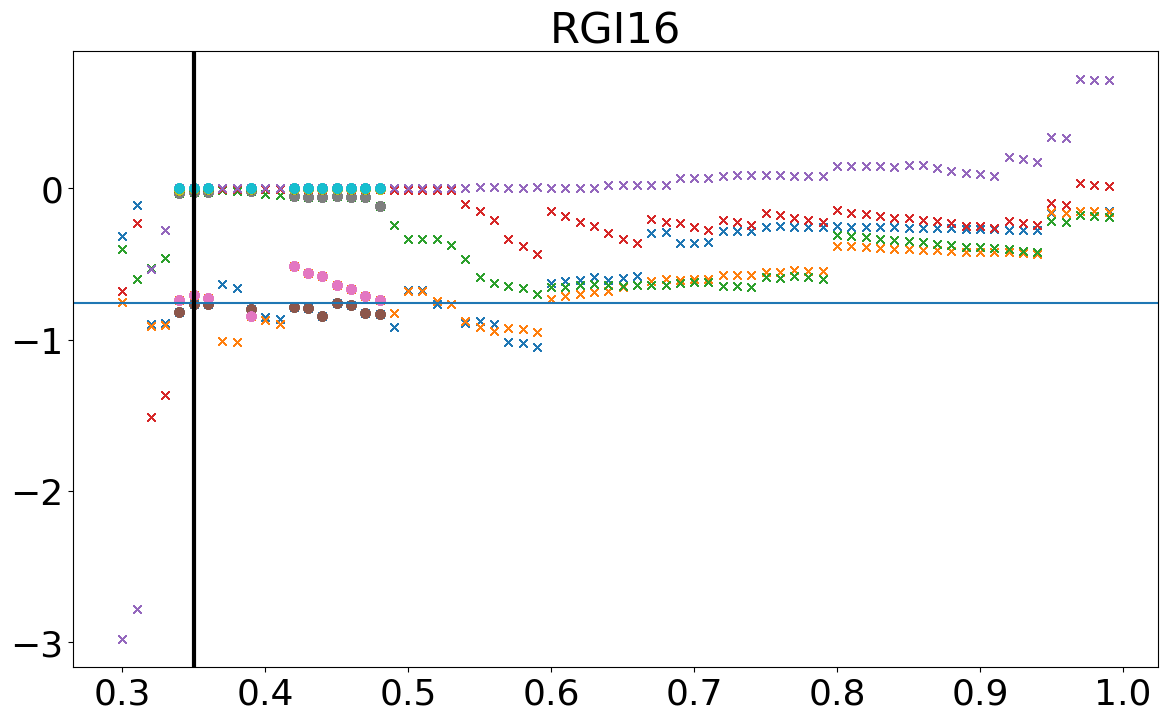

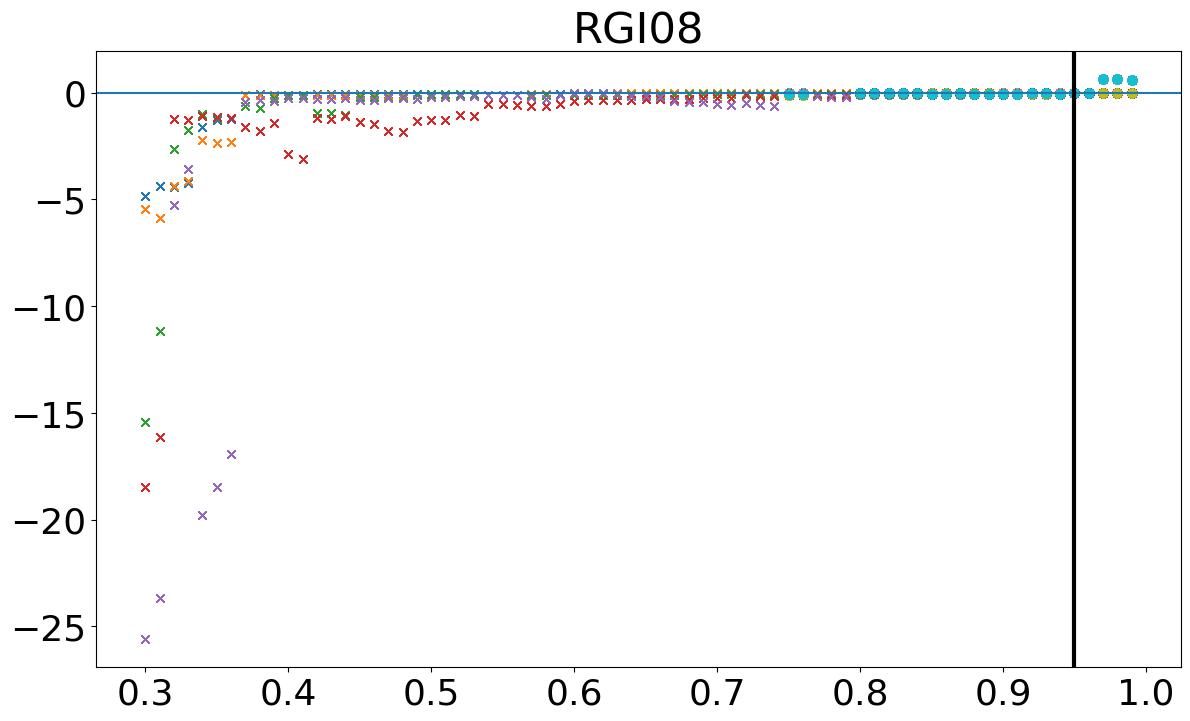

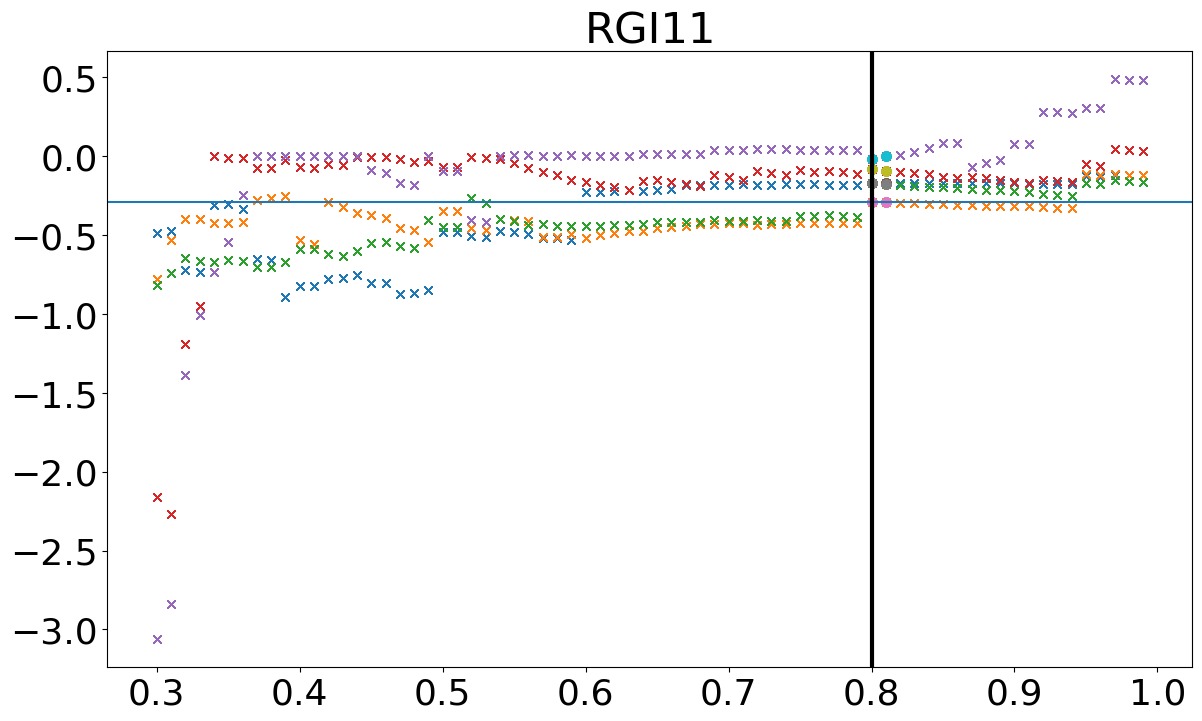

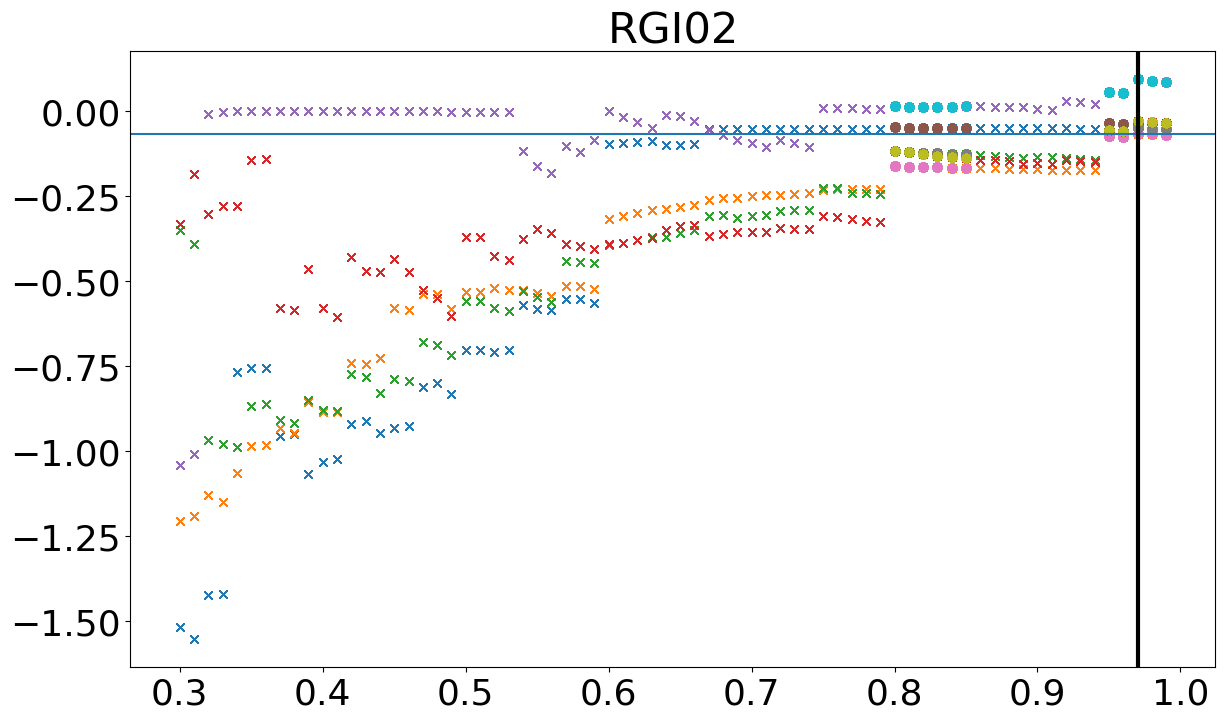

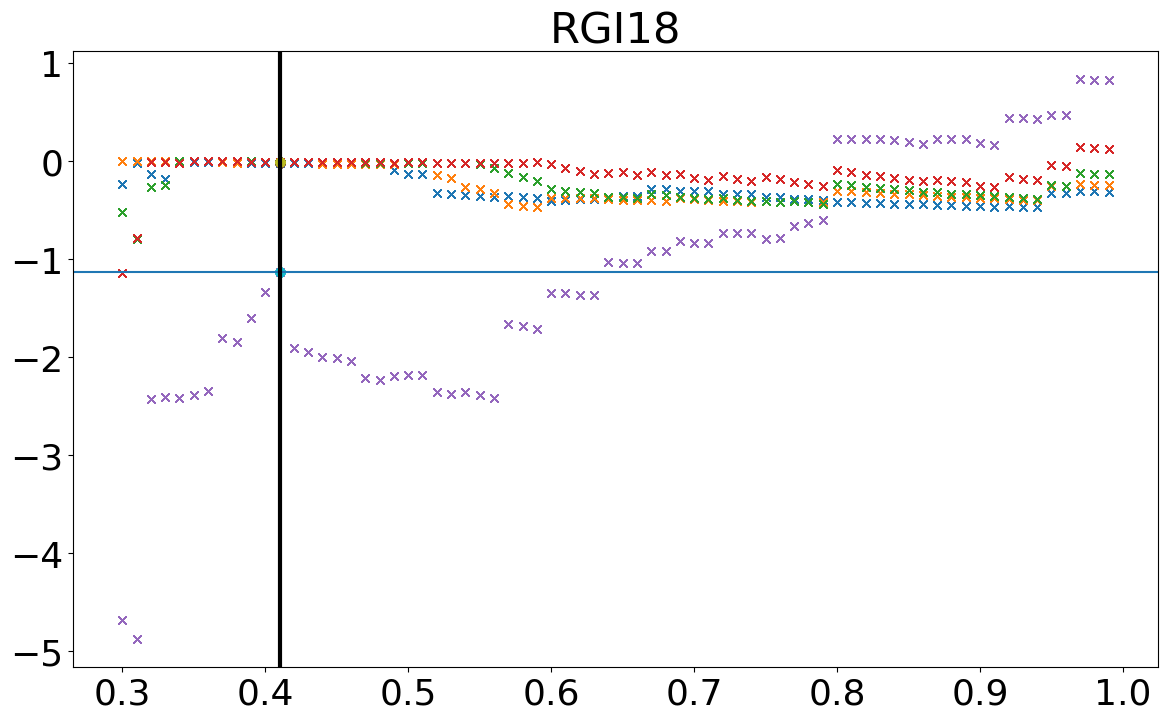

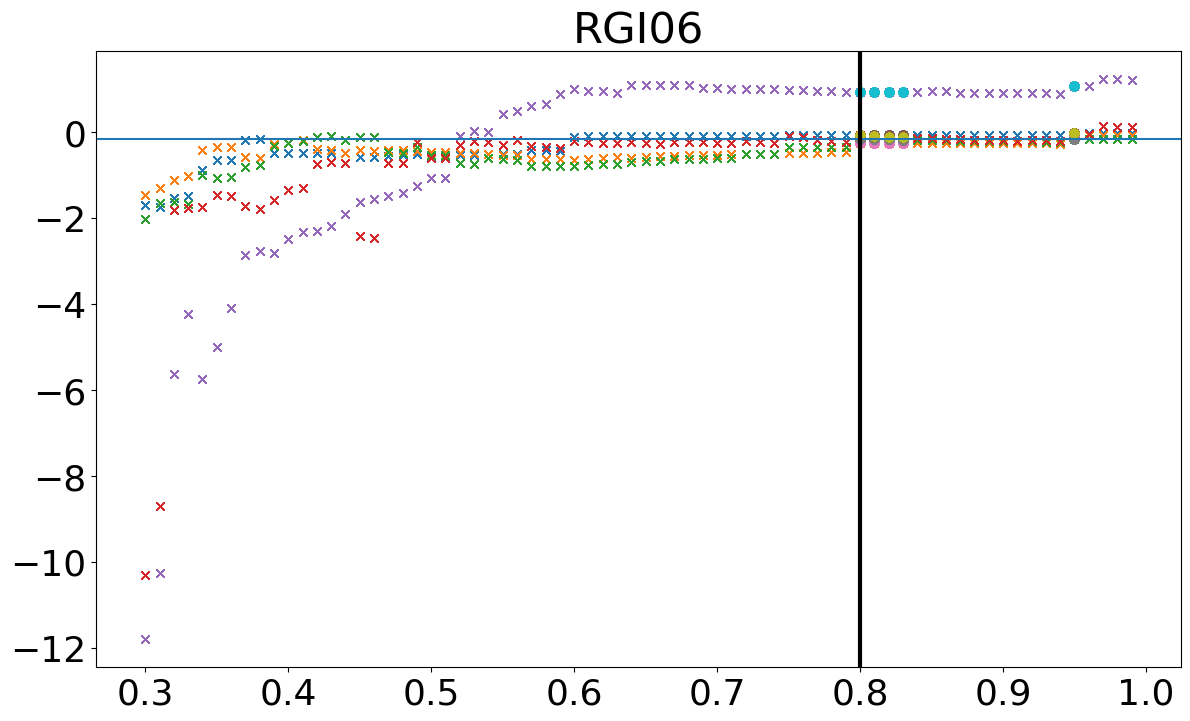

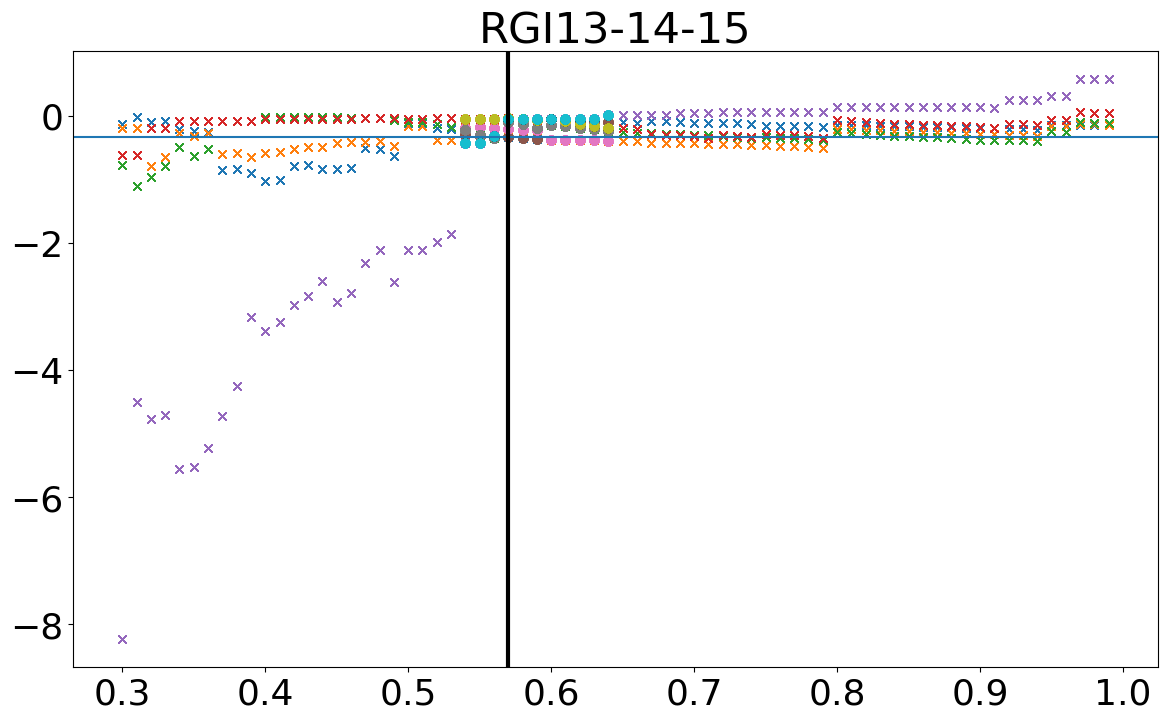

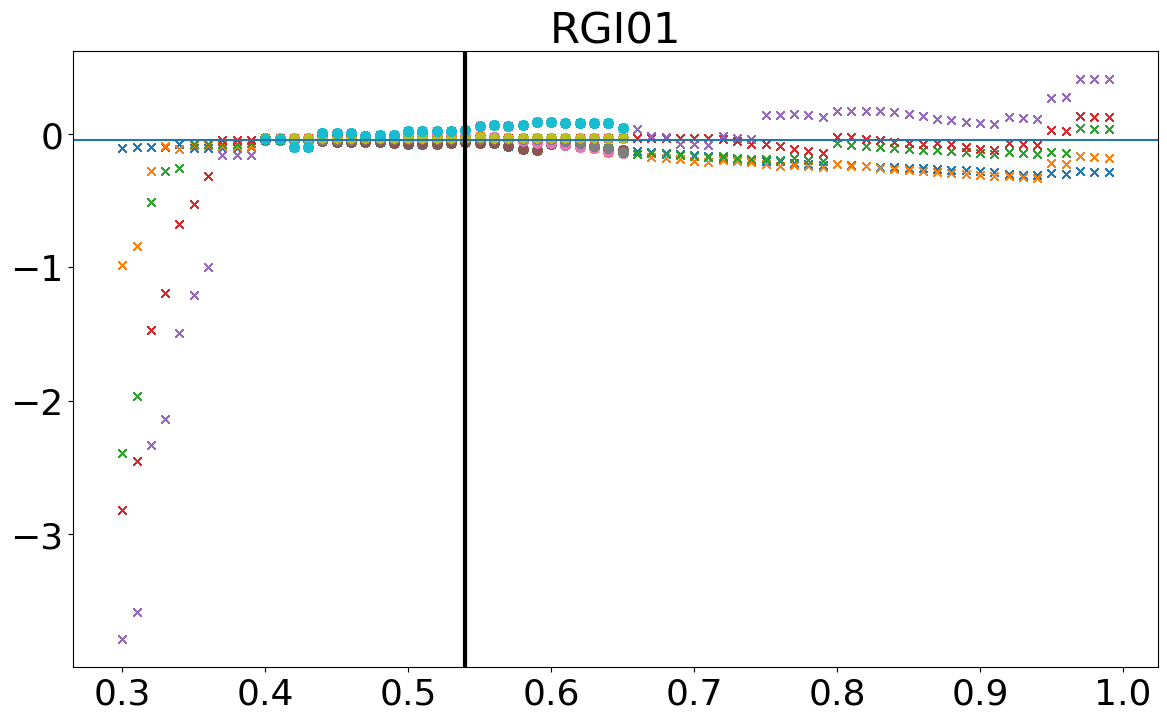

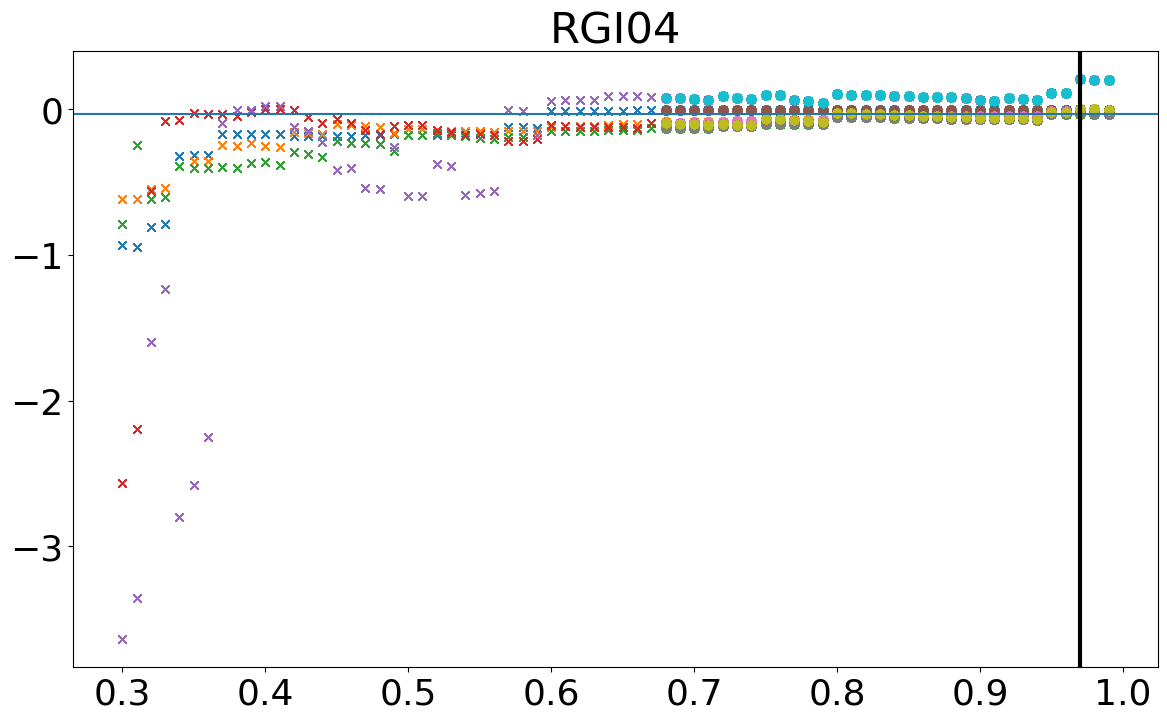

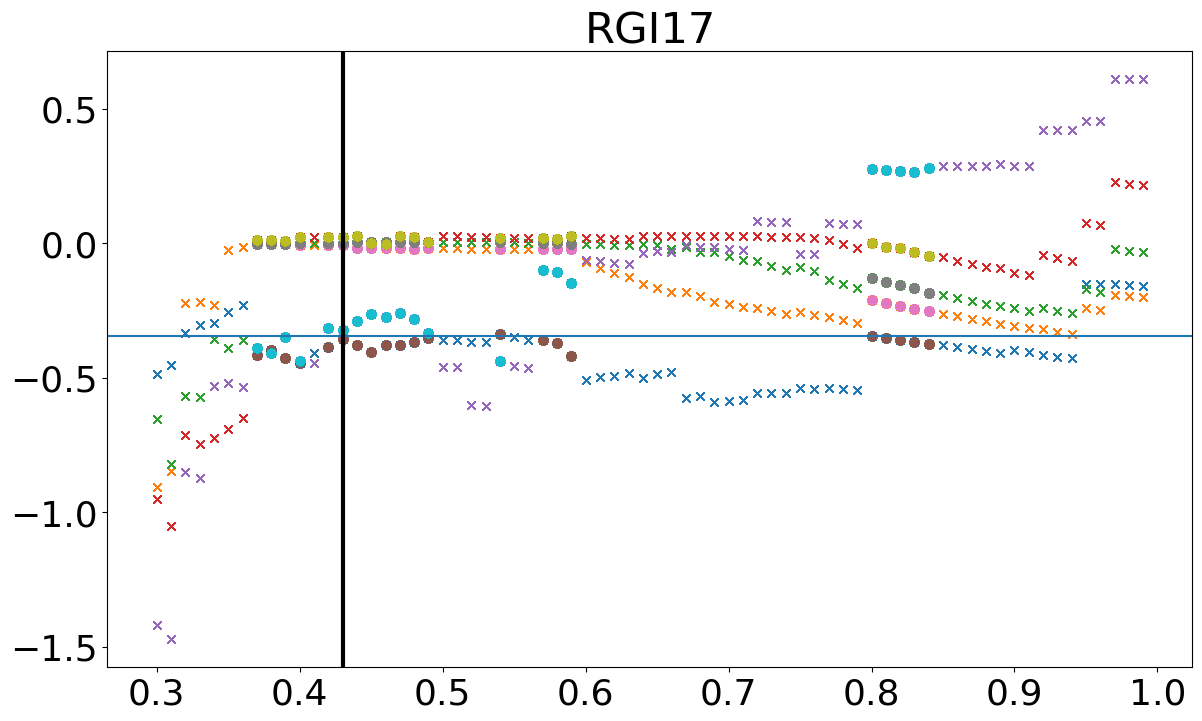

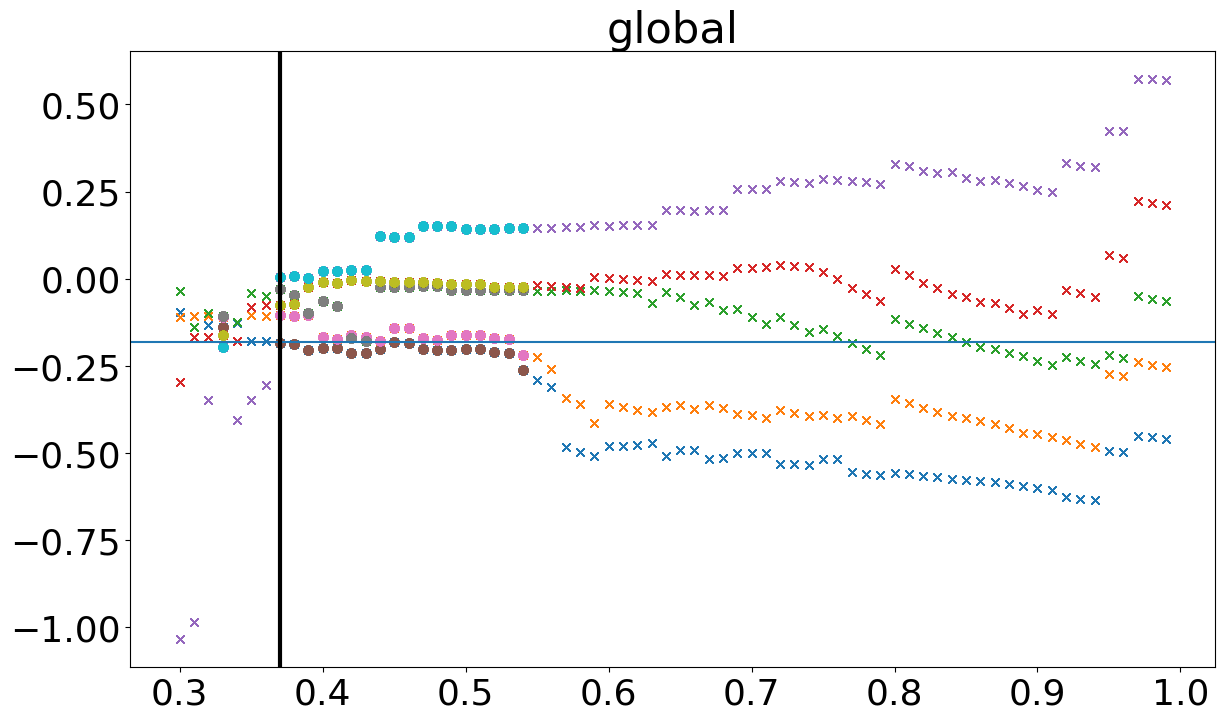

In [61]:
                    
sim_year = 2300
for reg in list(d_reg_num_name_icci_reg.keys()):
    rgi_regs = d_reg_num_name_icci_reg[reg]
    #fig, axs = plt.subplots(3,2, figsize=(25,22)) #harey=True, sharex=True)
    #fig_fit, axs_fit = plt.subplots(3,2, figsize=(25,22)) #harey=True, sharex=True)
    #axs_fit = axs_fit.flatten()
    #axs = axs.flatten()
    len_sub_p = len(rgi_regs)

    for jj,_rgi_reg in enumerate(rgi_regs): 
        list_index_l = []
        err_l = []
        for m in path_d.keys():
            list_index_l.append(list(pd_cmip_temp_ch_2100.index + '_' + m))
        pd_proj_2100_2300 = pd.DataFrame(index=np.concatenate(list_index_l))
        #pd_proj_2100_2300 = pd.DataFrame(index=pd_cmip_temp_ch_2100.index)

        if _rgi_reg !='global':
            rgi_reg = f'RGI{_rgi_reg}'
        else:
            rgi_reg = _rgi_reg

        pd_fit_stats_reg = pd_fit_stats.loc[pd_fit_stats.region == rgi_reg]
        pd_fit_stats_reg_lowess = pd_fit_stats_reg.loc[pd_fit_stats_reg.fit_opt == 'lowess_predi']
        pd_fit_stats_reg_exp = pd_fit_stats_reg.loc[pd_fit_stats_reg.fit_opt == 'exp']
        sel_it = pd_fit_stats_reg_lowess # we don't have it anymore ... .loc[pd_fit_stats_reg_lowess.it ==it]

        diff_min = 0
        repeat = True
        while repeat:
            _sel = sel_it.loc[sel_it.year == sim_year].copy()
            _sel_a = sel_it.loc[sel_it.year == sim_year].copy()

            if diff_min == 0:
                plt.figure()
                plt.plot(_sel.frac, _sel.min_q05_diff,'x')
                plt.plot(_sel.frac, _sel.min_q25_diff,'x')
                plt.plot(_sel.frac, _sel.min_q50_diff,'x')
                plt.plot(_sel.frac, _sel.min_q75_diff,'x')
                plt.plot(_sel.frac, _sel.min_q95_diff,'x')
            
            
            # also make sure to select a non-negative median
            # this does NOT work in some regions, we will just clip negative values afterwards ... 
            _sel = _sel.loc[(_sel['min_q50']>= -2) | (_sel['min_q50'] >= _sel['min_q50'].max())]
            
            # first choose only those that have the lowest fraction 
            min_q_diff = _sel[['min_q05_diff','min_q25_diff','min_q50_diff','min_q75_diff','min_q95_diff']].min(axis=1)
            _sel.loc[min_q_diff.index,'min_q_diff'] = min_q_diff.values
            max_min_q_diff = _sel['min_q_diff'].max()

            _sel = _sel.loc[_sel['min_q_diff'] >= max_min_q_diff-0.1]
            
            #if rgi_reg == 'global':
            #    print(_sel['min_q50'].unique())
            if diff_min == 0:
                plt.title(rgi_reg)
                plt.plot(_sel.frac, _sel.min_q05_diff,'o')
                plt.plot(_sel.frac, _sel.min_q25_diff,'o')
                plt.plot(_sel.frac, _sel.min_q50_diff,'o')
                plt.plot(_sel.frac, _sel.min_q75_diff,'o')
                plt.plot(_sel.frac, _sel.min_q95_diff,'o')
                plt.axhline(max_min_q_diff)
            _sel = _sel.loc[_sel.min_q50_diff>=-0.01-diff_min/5]
            _sel = _sel.loc[_sel.min_q95_diff>=-0.01-diff_min]
            _sel = _sel.loc[_sel.min_q75_diff>=-0.01-diff_min]
            _sel = _sel.loc[_sel.min_q25_diff>=-0.01-diff_min]
            _sel = _sel.loc[_sel.min_q05_diff>=-0.01-diff_min]

            _val = _sel.min_q50.max() if _sel.min_q50.max() <=0 else 0
            _sel = _sel.loc[_sel.min_q50 >=_val]
            _val = _sel.min_q05.max() if _sel.min_q05.max()<=0 else 0
            _sel = _sel.loc[_sel.min_q05 >=_val]
            if len(_sel) == 97:
                frac = np.round(_sel.frac.unique(),2)[0]
                repeat = False

            elif len(_sel)>97:
                frac = np.round(_sel.frac.unique().max(),2)
                repeat = False
            else:
                repeat = True
                diff_min = diff_min + 0.01
                if diff_min >=5:
                    break
                #    proble
                #    #frac = np.round(_sel.frac.unique(),2)[0]
                #    print('problem', rgi_reg, sim_year, #frac,
                #          diff_min)
        plt.axvline(frac, lw=3, color='black')
        print(frac, rgi_reg, max_min_q_diff, diff_min, _sel.min_q05_diff.max(), _sel.min_q95_diff.max(), _sel.min_q50.min())
        